**Mount Google Drive**

In [ ]:
#!rm -rf /content/drive

from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/PA/data/preprocessed"



Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Check for GPU (T4)**

In [ ]:
!nvidia-smi

Thu Nov 20 11:54:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              8W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!ls /content/drive/MyDrive/data/preprocessed

fast_features_replicate_1_lowering_raw.csv  pressures_replicate_1_lowering.json
fast_features_replicate_2_lowering_raw.csv  pressures_replicate_2.json
features_replicate_1.csv		    pressures_replicate_2_lowering.json
nozzles_replicate_1.json		    tensor_replicate_1_lowering.npy
nozzles_replicate_1_lowering.json	    tensor_replicate_1.npy
nozzles_replicate_2.json		    tensor_replicate_2_lowering.npy
nozzles_replicate_2_lowering.json	    tensor_replicate_2.npy
pressures_replicate_1.json


**Define equation, estimate the initials, and fit to each waveform**

In [ ]:
from scipy.signal.windows import tukey
from scipy.signal import find_peaks, hilbert
from scipy.fft import rfftfreq, rfft
from scipy.optimize import curve_fit, least_squares
import numpy as np

# ------------------------------------------------------------
# Stable model (gamma > 0): y(t) = C + D*t + A*exp(-gamma*t)*sin(2π f t + phi)
# We fit in gamma, but return tau = 1/gamma to keep your downstream code the same.
# ------------------------------------------------------------
def damped_sine_baseline_gamma(t, A, gamma, f, phi, C, D):
    return C + D*t + A*np.exp(-gamma*t)*np.sin(2*np.pi*f*t + phi)

def _prep(y):
    return np.asarray(y, float)

def estimate_initials(t, y, dt):
    """
    Robust starting values for A, tau, f, phi, C, D.
    (Internally computes gamma0, but returns tau0 = 1/gamma0.)
    """
    y = _prep(y)
    t = np.asarray(t, float)

    # --- Baseline (C0, D0) via linear least squares on raw y ---
    X = np.vstack([np.ones_like(t), t]).T
    C0, D0 = np.linalg.lstsq(X, y, rcond=None)[0]

    # --- Detrend for oscillation estimation ---
    y_d = y - (C0 + D0*t)

    # --- Frequency via FFT peak with parabolic refinement ---
    w = tukey(len(y_d), 0.1)
    yw = y_d * w
    Y = np.abs(rfft(yw))
    freqs = rfftfreq(len(yw), dt)
    k = np.argmax(Y[1:]) + 1  # ignore DC bin
    f0 = max(freqs[k], 1.0)
    if 1 <= k < len(Y)-1:
        a, b, c = Y[k-1], Y[k], Y[k+1]
        denom = (a - 2*b + c)
        delta = 0.5*(a - c)/denom if denom != 0 else 0.0
        f0 = freqs[k] + delta*(freqs[1] - freqs[0])

    # --- Amplitude ---
    A0 = 0.7 * (np.max(y_d) - np.min(y_d))
    if not np.isfinite(A0) or A0 <= 0:
        A0 = 1.0

    # --- Decay from log-envelope of peaks -> gamma0 > 0 ---
    min_dist = max(1, int(0.3/(max(f0,1.0)*dt)))
    pk, _ = find_peaks(np.abs(y_d), distance=min_dist)
    if len(pk) >= 3:
        tk = t[pk]
        ak = np.abs(y_d[pk]) + 1e-12
        slope, _ = np.polyfit(tk, np.log(ak), 1)  # for decay, slope ~ -gamma
        gamma0 = max(-slope, 1e4)                 # clip to positive
    else:
        gamma0 = 1.0/10e-6  # gamma ~ 100 kHz (tau ≈ 10 μs) fallback

    # --- Phase guess (pick better of two) on detrended y ---
    try:
        phi_h = np.unwrap(np.angle(hilbert(y_d))) - 2*np.pi*f0*t
        phi_h = (np.mean(phi_h) + np.pi) % (2*np.pi) - np.pi
    except Exception:
        phi_h = 0.0

    idx = int(np.argmax(np.abs(y_d)))
    if idx == 0: idx = 1
    dy = y_d[idx] - y_d[idx-1]
    phi_d = np.arctan2(dy/dt, 2*np.pi*f0*y_d[idx])

    s_h = np.corrcoef(y_d, A0*np.exp(-gamma0*t)*np.sin(2*np.pi*f0*t + phi_h))[0,1]
    s_d = np.corrcoef(y_d, A0*np.exp(-gamma0*t)*np.sin(2*np.pi*f0*t + phi_d))[0,1]
    phi0 = phi_h if np.abs(s_h) >= np.abs(s_d) else phi_d

    tau0 = 1.0/gamma0  # return tau for compatibility
    return float(A0), float(tau0), float(f0), float(phi0), float(C0), float(D0)

def fit_one(t, y, dt, bounds=None, robust=False):
    """
    Fit damped sinusoid + linear baseline using stable gamma parameterization.
    Returns popt, yhat, rmse, nrmse with popt = [A, tau, f, phi, C, D]
    Set robust=True to use soft-L1 loss (better with spikes/outliers).
    """
    t = np.asarray(t, float)
    y = np.asarray(y, float)

    # Initials (returns tau0; convert to gamma0)
    A0, tau0, f0, phi0, C0, D0 = estimate_initials(t, y, dt)
    gamma0 = max(1.0/abs(tau0), 1e4)  # ensure > 0

    # Bounds (in gamma space)
    if bounds is None:
        # A, gamma, f, phi, C, D
        bounds = (
            [0.0, 1e4, 5e3, -np.pi, -1e6, -1e9],
            [1e9, 1e7, 3e5,  np.pi,  1e6,  1e9],
        )

    # Build seeds (vary f and phi; keep C,D from LS; use gamma0)
    seeds = []
    for fscale in [0.95, 1.0, 1.05]:
        for dphi in [0.0, np.pi/2, -np.pi/2]:
            seeds.append([
                max(A0, 1e-12),
                np.clip(gamma0, bounds[0][1], bounds[1][1]),
                np.clip(f0 * fscale, bounds[0][2], bounds[1][2]),
                ((phi0 + dphi + np.pi) % (2*np.pi)) - np.pi,
                np.clip(C0, bounds[0][4], bounds[1][4]),
                np.clip(D0, bounds[0][5], bounds[1][5]),
            ])

    best = None

    if robust:
        # Robust solver (soft-L1)
        def resid_fun(p):
            return y - damped_sine_baseline_gamma(t, *p)
        for p0 in seeds:
            try:
                res = least_squares(resid_fun, p0, bounds=bounds, loss='soft_l1', f_scale=1.0, max_nfev=20000)
                p = res.x
                yhat = damped_sine_baseline_gamma(t, *p)
                r = y - yhat
                rmse = np.sqrt(np.mean(r**2))
                nrmse = rmse / (np.ptp(y) + 1e-12)
                score = nrmse
                if (best is None) or (score < best[0]):
                    best = (score, p, yhat, rmse, nrmse)
            except Exception:
                continue
    else:
        # Classic LS (curve_fit)
        for p0 in seeds:
            try:
                popt_g, _ = curve_fit(damped_sine_baseline_gamma, t, y, p0=p0, bounds=bounds, maxfev=20000)
                yhat = damped_sine_baseline_gamma(t, *popt_g)
                r = y - yhat
                rmse = np.sqrt(np.mean(r**2))
                nrmse = rmse / (np.ptp(y) + 1e-12)
                score = nrmse
                if (best is None) or (score < best[0]):
                    best = (score, popt_g, yhat, rmse, nrmse)
            except Exception:
                continue

    if best is None:
        # Fall back to initials
        popt_g = np.array([A0, gamma0, f0, phi0, C0, D0], float)
        yhat = damped_sine_baseline_gamma(t, *popt_g)
        r = y - yhat
        rmse = np.sqrt(np.mean(r**2))
        nrmse = rmse / (np.ptp(y) + 1e-12)
    else:
        _, popt_g, yhat, rmse, nrmse = best

    # Convert back to tau for output compatibility
    A, gamma, f, phi, C, D = popt_g
    tau = 1.0 / gamma
    popt = np.array([A, tau, f, phi, C, D], float)

    return popt, yhat, rmse, nrmse


# ---------- Windowed fitting utilities ----------

def _coarse_freq(y, dt):
    from scipy.fft import rfft, rfftfreq
    Y = np.abs(rfft(y - np.mean(y)))
    F = rfftfreq(len(y), dt)
    k = np.argmax(Y[1:]) + 1
    f0 = max(F[k], 1.0)
    if 1 <= k < len(Y)-1:
        a, b, c = Y[k-1], Y[k], Y[k+1]
        denom = (a - 2*b + c)
        delta = 0.5*(a - c)/denom if denom != 0 else 0.0
        f0 = F[k] + delta*(F[1]-F[0])
    return f0

def _make_local_bounds(prev, ratios, hard_bounds=None):
    """
    Build bounds around previous params (A, tau, f, phi, C, D) but RETURN them
    in (A, gamma, f, phi, C, D) because fit_one() fits gamma.
    ratios: multiplicative for A,tau,f; additive for phi,C,D.
    """
    A, tau, f, phi, C, D = prev
    tau = float(max(tau, 1e-9))

    # propose tau-bounds around the previous value
    A_lo, A_hi   = A*(1-ratios['A']),   A*(1+ratios['A'])
    tau_lo, tau_hi = tau*(1-ratios['tau']), tau*(1+ratios['tau'])
    f_lo, f_hi   = f*(1-ratios['f']),   f*(1+ratios['f'])
    phi_lo,phi_hi= phi - ratios['phi'], phi + ratios['phi']
    C_lo,  C_hi  = C - ratios['C'],     C + ratios['C']
    D_lo,  D_hi  = D - ratios['D'],     D + ratios['D']

    # convert tau-bounds -> gamma-bounds (monotone invert, swap lo/hi)
    tau_lo = max(tau_lo, 1e-12)
    tau_hi = max(tau_hi, 1.01*tau_lo)
    gamma_lo = 1.0 / tau_hi   # smaller gamma = longer tau
    gamma_hi = 1.0 / tau_lo   # larger gamma = shorter tau

    lo = np.array([A_lo, gamma_lo, f_lo, phi_lo, C_lo, D_lo], float)
    hi = np.array([A_hi, gamma_hi, f_hi, phi_hi, C_hi, D_hi], float)

    if hard_bounds is not None:
        # hard_bounds must also be in (A, gamma, f, phi, C, D)
        lo = np.maximum(lo, hard_bounds[0])
        hi = np.minimum(hi, hard_bounds[1])

    return (lo, hi)


def fit_sliding_windows(t, y, dt, cycles=6, overlap=0.5,
                        robust=True,
                        local_ratio=None,
                        use_weight='tukey'):
    """
    Windowed fitting with overlap-add.
    Returns:
        yhat_oa : overlap-add reconstruction over full t
        params  : array (nwin, 6) of [A, tau, f, phi, C, D] per window
        nrmse   : array (nwin,) window nrmse
        idxs    : list of slice objects for each window on original t
        meta    : dict with L, H, f0
    """
    y = np.asarray(y, float)
    t = np.asarray(t, float)

    # coarse frequency to set window length ~ cycles/f0
    f0 = _coarse_freq(y, dt)
    L = int(max(64, np.round((cycles / max(f0, 1.0)) / dt)))  # samples per window
    H = int(max(1, np.round(L * (1 - overlap))))              # hop
    if L > len(y):  # degenerate case
        L = len(y)
        H = max(1, L // 2)

    # --- analysis/synthesis windows ---
    # Interior frames: tapered; first/last: rectangular to avoid edge collapse
    if use_weight == 'tukey':
        w_core = tukey(L, 0.25)
    else:
        w_core = np.hanning(L)
    w_edge = np.ones(L)

    yhat_oa = np.zeros_like(y, float)
    wsum    = np.zeros_like(y, float)

    params_list = []
    nrmse_list  = []
    idxs        = []

    prev = None
    base_bounds = (
        [0.0, 1e4, 5e3, -np.pi, -1e9, -1e12],   # A, gamma, f, phi, C, D
        [1e9, 1e7, 3e5,  np.pi,  1e9,  1e12],
    )

    # default "slow drift" local constraints
    if local_ratio is None:
        local_ratio = dict(A=0.5, tau=0.5, f=0.2, phi=np.pi/3, C=5e4, D=1e10)

    for wi, start in enumerate(range(0, len(y) - L + 1, H)):
        sl = slice(start, start + L)
        idxs.append(sl)
        t_win = t[sl]; y_win = y[sl]

        # build local bounds around previous params if available
        if prev is not None and np.all(np.isfinite(prev)):
            bounds_local = _make_local_bounds(prev, local_ratio, base_bounds)
        else:
            bounds_local = base_bounds

        popt, yhat_win, rmse, nrm = fit_one(t_win, y_win, dt,
                                            bounds=bounds_local,
                                            robust=robust)

        params_list.append(popt)
        nrmse_list.append(nrm)

        # --- edge-safe overlap-add ---
        is_last = (start + L >= len(y))
        w_use = w_edge if (wi == 0 or is_last) else w_core
        yhat_oa[sl] += w_use * yhat_win
        wsum[sl]    += w_use

        prev = popt

    # avoid division by tiny numbers at very edges
    wsum_safe = np.where(wsum > 1e-9, wsum, 1.0)
    yhat_oa /= wsum_safe

    params_arr = np.vstack(params_list)
    nrmse_arr  = np.array(nrmse_list)

    meta = dict(L=L, H=H, f0=f0, cycles=cycles, overlap=overlap)
    return yhat_oa, params_arr, nrmse_arr, idxs, meta


def summarize_windows(params_arr, nrmse_arr, mode='nrmse'):
    """
    Weighted summary of window parameters.
    Returns a 6-vector [A, tau, f, phi, C, D] (phi left as circular mean).
    """
    A, tau, f, phi, C, D = params_arr.T
    gamma = 1/np.clip(tau, 1e-12, None)

    if mode == 'nrmse':
        w = 1/np.clip(nrmse_arr, 1e-6, None)**2
    elif mode == 'amplitude':
        w = np.clip(A, 1e-12, None)**2
    else:
        w = np.ones_like(A)

    def wmean(x): return float(np.sum(w*x)/np.sum(w))
    Abar = wmean(A)
    gbar = wmean(gamma); taubar = 1.0/max(gbar, 1e-12)
    fbar = wmean(f)
    Cbar = wmean(C); Dbar = wmean(D)

    # circular mean for phase (optional; often refit is better)
    sinp = wmean(np.sin(phi)); cosp = wmean(np.cos(phi))
    phibar = float(np.arctan2(sinp, cosp))
    return np.array([Abar, taubar, fbar, phibar, Cbar, Dbar], float)





**Inverting signal**

In [ ]:
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Windowed fit hyperparams (fallbacks)
try: WIN_CYCLES
except NameError: WIN_CYCLES = 6.0
try: WIN_OVERLAP
except NameError: WIN_OVERLAP = 0.50

# ---------- 1) choose ~200 low-phase signals ----------
phi_all = params6_all[:, :, 3]   # φ from [A, tau, f, phi, C, D]

# use your LOW_MAX if it exists, otherwise default to -0.5 rad
try:
    LOW_MAX
except NameError:
    LOW_MAX = -0.5

low_mask  = (phi_all <= LOW_MAX)
low_pairs = np.argwhere(low_mask)  # array of [nozzle_idx, pressure_idx]

print(f"Found {len(low_pairs)} low-phase (≤ {LOW_MAX} rad) signals.")

# take at most 2000 random ones
np.random.seed(0)
if len(low_pairs) > 2000:
    sel_idx = np.random.choice(len(low_pairs), size=2000, replace=False)
    low_pairs_sel = low_pairs[sel_idx]
else:
    low_pairs_sel = low_pairs

print(f"Using {len(low_pairs_sel)} signals for the experiment.")

# ---------- 2) reflect signals around mid-value & refit ----------
rows = []

for nozzle_idx, pressure_idx in low_pairs_sel:
    # original signal
    y = tensor[nozzle_idx, :, pressure_idx]

    # reflect around mid-point of the value range
    y_min, y_max = y.min(), y.max()
    y_mid = 0.5 * (y_min + y_max)
    y_ref = 2 * y_mid - y

    # original fitted params (from your merged file)
    A0, tau0, f0, phi0, C0, D0 = params6_all[nozzle_idx, pressure_idx, :]

    # refit reflected signal using the same OA-seed pipeline
    yhat_ref, p_win_ref, nrmse_win_ref, _, _ = fit_sliding_windows(
        t, y_ref, dt, cycles=WIN_CYCLES, overlap=WIN_OVERLAP, robust=True
    )
    A1, tau1, f1, phi1, C1, D1 = summarize_windows(p_win_ref, nrmse_win_ref, mode='nrmse')

    # quick NRMSE for the reflected fit
    rmse_ref  = np.sqrt(np.mean((y_ref - yhat_ref) ** 2))
    nrmse_ref = rmse_ref / (np.ptp(y_ref) + 1e-12)

    rows.append(dict(
        nozzle=nozzle_idx,
        pressure_idx=pressure_idx,
        A_old=A0,   tau_old=tau0,   f_old=f0,   phi_old=phi0,
        C_old=C0,   D_old=D0,
        A_new=A1,   tau_new=tau1,   f_new=f1,   phi_new=phi1,
        C_new=C1,   D_new=D1,
        nrmse_new=nrmse_ref,
    ))

df = pd.DataFrame(rows)

# add Q and phase-difference for convenience
df["Q_old"] = np.pi * df["f_old"] * df["tau_old"]
df["Q_new"] = np.pi * df["f_new"] * df["tau_new"]
df["phi_diff"] = ((df["phi_new"] - df["phi_old"] + np.pi) % (2*np.pi)) - np.pi

print("First few rows of old vs new parameters:")
display(df.head())

# ---------- 3) pair-style scatter plots: old vs new parameters ----------
params_to_plot = ["A", "tau", "f", "phi", "C", "D", "Q"]

n_par = len(params_to_plot)
n_cols = 4
n_rows = int(np.ceil(n_par / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.5*n_rows))
axes = axes.ravel()

for i, par in enumerate(params_to_plot):
    ax = axes[i]
    x = df[f"{par}_old"].values
    y = df[f"{par}_new"].values

    ax.scatter(x, y, s=20, alpha=0.6)
    # 1:1 line
    finite_mask = np.isfinite(x) & np.isfinite(y)
    if np.any(finite_mask):
        x_f = x[finite_mask]; y_f = y[finite_mask]
        lo = min(x_f.min(), y_f.min())
        hi = max(x_f.max(), y_f.max())
        pad = 0.05 * (hi - lo if hi > lo else 1.0)
        lo -= pad; hi += pad
        ax.plot([lo, hi], [lo, hi], "k--", linewidth=1)
        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)

    ax.set_xlabel(f"{par} (original fit)")
    ax.set_ylabel(f"{par} (reflected fit)")
    ax.set_title(par)
    ax.grid(True)

# hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# ---------- 4) extra: histogram of phase change ----------
plt.figure(figsize=(6,4))
plt.hist(df["phi_diff"], bins=30, edgecolor="k", alpha=0.7)
plt.xlabel("φ_new - φ_old (wrapped to [-π, π]) [rad]")
plt.ylabel("Count")
plt.title("Phase shift after midline reflection + refit")
plt.grid(True)
plt.tight_layout()
plt.show()
"""


'\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Windowed fit hyperparams (fallbacks)\ntry: WIN_CYCLES\nexcept NameError: WIN_CYCLES = 6.0\ntry: WIN_OVERLAP\nexcept NameError: WIN_OVERLAP = 0.50\n\n# ---------- 1) choose ~200 low-phase signals ----------\nphi_all = params6_all[:, :, 3]   # φ from [A, tau, f, phi, C, D]\n\n# use your LOW_MAX if it exists, otherwise default to -0.5 rad\ntry:\n    LOW_MAX\nexcept NameError:\n    LOW_MAX = -0.5\n\nlow_mask  = (phi_all <= LOW_MAX)\nlow_pairs = np.argwhere(low_mask)  # array of [nozzle_idx, pressure_idx]\n\nprint(f"Found {len(low_pairs)} low-phase (≤ {LOW_MAX} rad) signals.")\n\n# take at most 2000 random ones\nnp.random.seed(0)\nif len(low_pairs) > 2000:\n    sel_idx = np.random.choice(len(low_pairs), size=2000, replace=False)\n    low_pairs_sel = low_pairs[sel_idx]\nelse:\n    low_pairs_sel = low_pairs\n\nprint(f"Using {len(low_pairs_sel)} signals for the experiment.")\n\n# ---------- 2) reflect signals arou

**New fitting loop**

In [ ]:
"""
# ==== Phase-corrected OA-seed fitting: invert signals with negative phase ====
import os, re, json, datetime
import numpy as np
import multiprocessing
from joblib import Parallel, delayed

# ------------ CONFIG ------------
replicate = 1

base_pre  = "/content/drive/MyDrive/data/preprocessed"
base_ring = "/content/drive/MyDrive/data/ringdown"

# (1) old merged file with original phases
MERGE_DIR_OLD  = "/content/drive/MyDrive/data/fit"
MERGED_OLDNAME = f"merged_rep_{replicate}_lowering_params6_Q_rmse_nrmse.npz"
MERGED_OLDPATH = os.path.join(MERGE_DIR_OLD, MERGED_OLDNAME)

# (2) NEW output directory for phase-corrected partial fits
OUT_DIR = "/content/drive/MyDrive/data/ringdown/oa_fit_results_rep_1_phaseflipped_negphi"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------ LOAD DATA ------------
tensor_path = os.path.join(base_ring, f"tensor_replicate_{replicate}_lowering_ringdown.npy")
press_path  = os.path.join(base_pre,  f"pressures_replicate_{replicate}_lowering.json")
nozz_path   = os.path.join(base_pre,  f"nozzles_replicate_{replicate}_lowering.json")

tensor = np.load(tensor_path, allow_pickle=True)
with open(press_path, "r") as f: pressures = np.array(json.load(f), dtype=float)
with open(nozz_path,  "r") as f: nozzles   = json.load(f)

n_nozzles, n_samples, n_pressures = tensor.shape
fs = 4.125e6
dt = 1 / fs
t  = np.arange(n_samples) * dt

print(f" Loaded tensor: {tensor.shape} (nozzles × samples × pressures)")

# ------------ LOAD ORIGINAL PHASES & BUILD MASK ------------
if not os.path.exists(MERGED_OLDPATH):
    raise FileNotFoundError(f"Old merged file not found: {MERGED_OLDPATH}")

merged_old   = np.load(MERGED_OLDPATH, allow_pickle=True)
params6_old  = merged_old["params6_all"]        # (n_nozzles, n_pressures, 6)
phi_old_all  = params6_old[:, :, 3]             # original phases
neg_mask     = phi_old_all < 0.0               # True where φ < 0

n_neg = int(np.sum(neg_mask))
print(f" Signals with negative original phase: {n_neg} / {n_nozzles*n_pressures}")

# Save the mask once so we can reuse it later (e.g. in merged NPZ)
neg_mask_path = os.path.join(OUT_DIR, "neg_phase_mask.npy")
np.save(neg_mask_path, neg_mask)
print(f" Saved neg_phase_mask to: {neg_mask_path}")

# ------------ Windowed fit hyperparams (fallbacks) ------------
try: WIN_CYCLES
except NameError: WIN_CYCLES = 6.0
try: WIN_OVERLAP
except NameError: WIN_OVERLAP = 0.50

# ------------ Resume logic (same pattern as before) ------------
print(f"Resuming / writing partials in folder: {OUT_DIR}")

pat = re.compile(r"^params6_partial_(\d+)_(\d+)\.npy$")
done_ranges = []
if os.path.isdir(OUT_DIR):
    for fname in os.listdir(OUT_DIR):
        m = pat.match(fname)
        if m:
            s, e = int(m.group(1)), int(m.group(2))
            done_ranges.append((s, e))
done_ranges.sort()

if done_ranges:
    max_done = max(e for (_, e) in done_ranges)
    RESUME_FROM = max_done + 1
else:
    RESUME_FROM = 0

print("Already completed ranges:", done_ranges[:5], "..." if len(done_ranges) > 5 else "")
print(f"  Will resume from nozzle index: {RESUME_FROM}")

done_batch_set = set(done_ranges)

# ------------ Helper: model with τ ------------
def damped_sine_baseline_tau(t, A, tau, f, phi, C, D):
    return C + D*t + A*np.exp(-t/np.clip(tau, 1e-12, None))*np.sin(2*np.pi*f*t + phi)

# ------------ Helper: reflect signal if its original phase was negative ------------
def maybe_reflect_signal(local_idx, k, y_raw):
    """
    """
    If original φ(local_idx, k) < 0, reflect y_raw around its mid-value
    y_mid = (min+max)/2, y_ref = 2*y_mid - y_raw.
    Otherwise, return y_raw unchanged.
    """
    """
    if neg_mask[local_idx, k]:
        y_min, y_max = y_raw.min(), y_raw.max()
        y_mid = 0.5 * (y_min + y_max)
        return 2*y_mid - y_raw
    else:
        return y_raw

# ------------ Fitting function for one nozzle ------------
def fit_nozzle(local_idx: int):
    local_params6 = np.full((n_pressures, 6), np.nan, dtype=float)
    local_Q       = np.full(n_pressures,     np.nan, dtype=float)
    local_rmse    = np.full(n_pressures,     np.nan, dtype=float)
    local_nrmse   = np.full(n_pressures,     np.nan, dtype=float)

    for k in range(n_pressures):
        y_raw = tensor[local_idx, :, k]
        y     = maybe_reflect_signal(local_idx, k, y_raw)

        try:
            yhat_k, p_win_k, nrmse_win_k, _, _ = fit_sliding_windows(
                t, y, dt, cycles=WIN_CYCLES, overlap=WIN_OVERLAP, robust=True
            )
            p_seed_k = summarize_windows(p_win_k, nrmse_win_k, mode='nrmse')  # [A, tau, f, phi, C, D]
            A, tau, f, phi, C, D = p_seed_k

            rmse_k  = np.sqrt(np.mean((y - yhat_k) ** 2))
            nrmse_k = rmse_k / (np.ptp(y) + 1e-12)
            Q_k     = np.pi * f * tau if (np.isfinite(f) and np.isfinite(tau) and tau > 0) else np.nan

            local_params6[k, :] = p_seed_k
            local_Q[k]          = Q_k
            local_rmse[k]       = rmse_k
            local_nrmse[k]      = nrmse_k

        except Exception as e:
            print(f"⚠️ OA fit failed for nozzle {local_idx}, pressure {k}: {e}")

    return local_params6, local_Q, local_rmse, local_nrmse

# ------------ Batch loop with Parallel ------------
n_jobs    = max(1, multiprocessing.cpu_count() - 1)
batch_size = 50
print(f"🚀 Phase-corrected fitting started at {datetime.datetime.now().strftime('%H:%M:%S')} using {n_jobs} cores...")

for batch_start in range(RESUME_FROM, n_nozzles, batch_size):
    batch_end    = min(batch_start + batch_size, n_nozzles)
    global_start = batch_start
    global_end   = batch_end - 1

    if (global_start, global_end) in done_batch_set:
        print(f"⏭  Skipping existing batch {global_start}-{global_end}")
        continue

    print(f"\n Processing nozzles {global_start}–{global_end}...")

    results = Parallel(n_jobs=n_jobs, verbose=5)(
        delayed(fit_nozzle)(i) for i in range(batch_start, batch_end)
    )

    params6_batch = np.array([r[0] for r in results])   # (B, n_pressures, 6)
    Q_batch       = np.array([r[1] for r in results])   # (B, n_pressures)
    rmse_batch    = np.array([r[2] for r in results])   # (B, n_pressures)
    nrmse_batch   = np.array([r[3] for r in results])   # (B, n_pressures)

    np.save(os.path.join(OUT_DIR, f"params6_partial_{global_start}_{global_end}.npy"), params6_batch)
    np.save(os.path.join(OUT_DIR, f"Q_partial_{global_start}_{global_end}.npy"),       Q_batch)
    np.save(os.path.join(OUT_DIR, f"rmse_partial_{global_start}_{global_end}.npy"),    rmse_batch)
    np.save(os.path.join(OUT_DIR, f"nrmse_partial_{global_start}_{global_end}.npy"),   nrmse_batch)

    print(f"💾 Saved phase-corrected partial batch {global_start}-{global_end}")

print(" Phase-corrected fitting completed.")
print(f" Finished at {datetime.datetime.now().strftime('%H:%M:%S')}")


<>:65: SyntaxWarning: invalid escape sequence '\d'
<>:65: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2283437063.py:65: SyntaxWarning: invalid escape sequence '\d'
  pat = re.compile(r"^params6_partial_(\d+)_(\d+)\.npy$")


IndentationError: unexpected indent (ipython-input-2283437063.py, line 93)

**New merge cell**

In [ ]:
"""
# ==== Merge PHASE-CORRECTED partials and save merged NPZ ====
import os, re, json
import numpy as np

# --------- SOURCE (where NEW partial files live) ----------
SRC_DIR = "/content/drive/MyDrive/data/ringdown/oa_fit_results_rep_1_phaseflipped_negphi"  # <-- must match OUT_DIR

# --------- DESTINATION (fixed) ----------
OUT_DIR = "/content/drive/MyDrive/data/fit"  # keep same main fit folder
os.makedirs(OUT_DIR, exist_ok=True)

replicate = 1
base_pre  = "/content/drive/MyDrive/data/preprocessed"
base_ring = "/content/drive/MyDrive/data/ringdown"

# --- load original tensor / meta to know shapes ---
tensor_path = os.path.join(base_ring, f"tensor_replicate_{replicate}_lowering_ringdown.npy")
press_path  = os.path.join(base_pre,  f"pressures_replicate_{replicate}_lowering.json")
nozz_path   = os.path.join(base_pre,  f"nozzles_replicate_{replicate}_lowering.json")

tensor = np.load(tensor_path, allow_pickle=True)
with open(press_path, "r") as f: pressures = np.array(json.load(f), dtype=float)
with open(nozz_path,  "r") as f: nozzles   = json.load(f)

n_nozzles, n_samples, n_pressures = tensor.shape
print(f" Tensor: {tensor.shape}  (nozzles × samples × pressures)")
print(f" Reading PHASE-CORRECTED partials from: {SRC_DIR}")
print(f" Will save merged file into: {OUT_DIR}")

# --- discover partials ---
pat = re.compile(r"^(params6|Q|rmse|nrmse)_partial_(\d+)_(\d+)\.npy$")
files = {}
for fname in os.listdir(SRC_DIR):
    m = pat.match(fname)
    if not m:
        continue
    kind, s, e = m.group(1), int(m.group(2)), int(m.group(3))
    files.setdefault((s, e), {})[kind] = os.path.join(SRC_DIR, fname)

if not files:
    raise FileNotFoundError("No phase-corrected partial files found in SRC_DIR.")

batches = sorted(files.items(), key=lambda kv: (kv[0][0], kv[0][1]))
labels  = ", ".join(f"{s}-{e}" for (s, e), _ in batches[:6])
more    = "..." if len(batches) > 6 else ""
print(f" Found {len(batches)} batch ranges: [{labels}] {more}")

# --- allocate merged arrays ---
params6_all = np.full((n_nozzles, n_pressures, 6), np.nan, dtype=float)
Q_all       = np.full((n_nozzles, n_pressures),    np.nan, dtype=float)
rmse_all    = np.full((n_nozzles, n_pressures),    np.nan, dtype=float)
nrmse_all   = np.full((n_nozzles, n_pressures),    np.nan, dtype=float)

filled   = np.zeros(n_nozzles, dtype=bool)
overlaps = []

# --- merge loop ---
for (s, e), group in batches:
    if "params6" not in group:
        print(f"  Skipping {s}-{e}: missing params6 file.")
        continue

    p6 = np.load(group["params6"])  # (B, n_pressures, 6)
    B  = p6.shape[0]
    if p6.ndim != 3 or p6.shape[1] != n_pressures or p6.shape[2] != 6:
        raise ValueError(f"Shape mismatch in {group['params6']}: {p6.shape} != (B,{n_pressures},6)")
    if B != (e - s + 1):
        raise ValueError(f"Range {s}-{e} implies B={e-s+1}, got {B}")

    Q  = np.load(group["Q"])     if "Q"     in group else None
    R  = np.load(group["rmse"])  if "rmse"  in group else None
    NR = np.load(group["nrmse"]) if "nrmse" in group else None

    if Q  is not None and Q.shape  != (B, n_pressures):   raise ValueError(f"Q shape mismatch: {Q.shape}")
    if R  is not None and R.shape  != (B, n_pressures):   raise ValueError(f"rmse shape mismatch: {R.shape}")
    if NR is not None and NR.shape != (B, n_pressures):   raise ValueError(f"nrmse shape mismatch: {NR.shape}")

    sl = slice(s, e+1)
    if np.any(filled[sl]):
        overlaps.append((s, e, np.where(filled[sl])[0] + s))

    params6_all[sl, :, :] = p6
    if Q  is not None: Q_all[sl, :]     = Q
    if R  is not None: rmse_all[sl, :]  = R
    if NR is not None: nrmse_all[sl, :] = NR
    filled[sl] = True

covered = np.where(filled)[0]
missing = np.where(~filled)[0]
print(f" Coverage: {covered.size}/{n_nozzles} nozzles ({covered.size/n_nozzles:.1%}) merged.")
if overlaps:
    overlap_labels = ", ".join(f"{s}-{e}" for (s, e, _) in overlaps[:3])
    more = "..." if len(overlaps) > 3 else ""
    print(f" Overlaps detected; later files overwrote earlier for ranges: [{overlap_labels}] {more}")
if missing.size:
    miss_path = os.path.join(OUT_DIR, "missing_nozzle_indices_phaseflipped.txt")
    np.savetxt(miss_path, missing, fmt="%d")
    print(f" Missing {missing.size} nozzle(s). Saved list to: {miss_path}")

# --- load neg_phase_mask from SRC_DIR ---
neg_mask_path = os.path.join(SRC_DIR, "neg_phase_mask.npy")
if os.path.exists(neg_mask_path):
    neg_phase_mask = np.load(neg_mask_path)
    assert neg_phase_mask.shape == (n_nozzles, n_pressures), \
        f"neg_phase_mask shape {neg_phase_mask.shape} != {(n_nozzles, n_pressures)}"
    print(" Loaded neg_phase_mask from phase-corrected run.")
else:
    neg_phase_mask = np.zeros((n_nozzles, n_pressures), dtype=bool)
    print(" neg_phase_mask.npy not found in SRC_DIR, using all-False mask.")

# --- save merged PHASE-CORRECTED npz ---
merged_path = os.path.join(
    OUT_DIR,
    f"merged_rep_{replicate}_lowering_phaseflipped_params6_Q_rmse_nrmse.npz"
)

np.savez_compressed(
    merged_path,
    params6_all=params6_all,
    Q_all=Q_all,
    rmse_all=rmse_all,
    nrmse_all=nrmse_all,
    pressures=pressures,
    nozzles=np.array(nozzles, dtype=object),
    neg_phase_mask=neg_phase_mask,
)

print(f"\n Saved PHASE-CORRECTED merged file: {merged_path}")

# Quick sanity ping
if covered.size:
    i, k = int(covered[0]), min(10, n_pressures-1)
    ok = np.all(np.isfinite(params6_all[i, k]))
    print(f"Sanity check — nozzle {i}, pressure {k}: params finite = {ok}")
"""

**Fixing last npz file**

In [ ]:
"""
import os, json
import numpy as np

# ------------------- CONFIG -------------------
replicate = 1
base_pre  = "/content/drive/MyDrive/data/preprocessed"
base_ring = "/content/drive/MyDrive/data/ringdown"
fit_dir   = "/content/drive/MyDrive/data/fit"

# paths to merged files
MERGED_ORIG_PATH = os.path.join(
    fit_dir,
    f"merged_rep_{replicate}_lowering_params6_Q_rmse_nrmse.npz"
)
MERGED_PF_PATH = os.path.join(
    fit_dir,
    f"merged_rep_{replicate}_lowering_phaseflipped_params6_Q_rmse_nrmse.npz"
)

# output path for the new, bank-corrected merged file
MERGED_BANKCORR_PATH = os.path.join(
    fit_dir,
    f"merged_rep_{replicate}_lowering_bankcorrected_params6_Q_rmse_nrmse.npz"
)

# ------------------- LOAD RAW DATA -------------------
tensor_path = os.path.join(base_ring, f"tensor_replicate_{replicate}_lowering_ringdown.npy")
press_path  = os.path.join(base_pre,  f"pressures_replicate_{replicate}_lowering.json")
nozz_path   = os.path.join(base_pre,  f"nozzles_replicate_{replicate}_lowering.json")

tensor = np.load(tensor_path, allow_pickle=True)
with open(press_path, "r") as f:
    pressures = np.array(json.load(f), dtype=float)
with open(nozz_path, "r") as f:
    nozzles = json.load(f)

n_nozzles, n_samples, n_pressures = tensor.shape
fs = 4.125e6
dt = 1.0 / fs
t  = np.arange(n_samples) * dt

print(f" tensor shape: {tensor.shape} (nozzles × samples × pressures)")

# ------------------- LOAD MERGED FILES -------------------
merged_orig = np.load(MERGED_ORIG_PATH, allow_pickle=True)
merged_pf   = np.load(MERGED_PF_PATH,   allow_pickle=True)

params6_orig = merged_orig["params6_all"]   # (n_nozzles, n_pressures, 6)
Q_orig       = merged_orig["Q_all"]
rmse_orig    = merged_orig["rmse_all"]
nrmse_orig   = merged_orig["nrmse_all"]

params6_pf   = merged_pf["params6_all"]
Q_pf         = merged_pf["Q_all"]
rmse_pf      = merged_pf["rmse_all"]
nrmse_pf     = merged_pf["nrmse_all"]

# this should be your "inverted" label; adjust key name if needed
if "neg_phase_mask" in merged_pf:
    inverted_label = merged_pf["neg_phase_mask"]   # True where signal was inverted in phaseflipped run
else:
    raise KeyError("Could not find 'neg_phase_mask' in phaseflipped merged NPZ; adjust the key name here.")

assert inverted_label.shape == (n_nozzles, n_pressures), \
    f"inverted_label shape {inverted_label.shape} != {(n_nozzles, n_pressures)}"

print(" Loaded original and phaseflipped merged parameter sets.")


# ------------------- DEFINE BANKS (robust: from nozzle labels) -------------------
# nozzles entries look like "A012", "B319", "C223", etc.
labels = [str(n) for n in nozzles]

bank_letters = np.array([s[0].upper() if s else "?" for s in labels])

bank_A = (bank_letters == "A")
bank_B = (bank_letters == "B")
bank_C = (bank_letters == "C")
bank_D = (bank_letters == "D")

assert (bank_A | bank_B | bank_C | bank_D).sum() == n_nozzles, \
    "Bank masks don't cover all nozzles; check nozzle labels?"

# Expand to (n_nozzles, n_pressures)
bankA_mask_2d = np.repeat(bank_A[:, None], n_pressures, axis=1)
bankB_mask_2d = np.repeat(bank_B[:, None], n_pressures, axis=1)
bankC_mask_2d = np.repeat(bank_C[:, None], n_pressures, axis=1)
bankD_mask_2d = np.repeat(bank_D[:, None], n_pressures, axis=1)

bankAC_mask = bankA_mask_2d | bankC_mask_2d   # these should be inverted
bankBD_mask = bankB_mask_2d | bankD_mask_2d   # these should NOT be inverted


assert (bank_A | bank_B | bank_C | bank_D).sum() == n_nozzles, "Bank masks don't cover all nozzles?"

# Expand to (n_nozzles, n_pressures)
bankA_mask_2d = np.repeat(bank_A[:, None], n_pressures, axis=1)
bankB_mask_2d = np.repeat(bank_B[:, None], n_pressures, axis=1)
bankC_mask_2d = np.repeat(bank_C[:, None], n_pressures, axis=1)
bankD_mask_2d = np.repeat(bank_D[:, None], n_pressures, axis=1)

bankAC_mask = bankA_mask_2d | bankC_mask_2d
bankBD_mask = bankB_mask_2d | bankD_mask_2d

# ------------------- DECISION MASKS -------------------
# A & C should be inverted:
#   - already inverted in pf → keep pf
#   - not inverted in pf → need to refit with inversion
need_refit_AC = bankAC_mask & (~inverted_label)

# B & D should NOT be inverted:
#   - inverted in pf → revert to original
#   - not inverted in pf → keep pf
use_orig_BD = bankBD_mask & inverted_label

print(f"Signals needing refit (A/C & not-inverted in pf): {need_refit_AC.sum()}")
print(f"Signals reverting to original (B/D & inverted in pf): {use_orig_BD.sum()}")

# ------------------- START FINAL ARRAYS -------------------
# Start from phaseflipped parameters and then selectively override
params6_final = params6_pf.copy()
Q_final       = Q_pf.copy()
rmse_final    = rmse_pf.copy()
nrmse_final   = nrmse_pf.copy()

# First: for Bank B & D where pf inverted but we don't want inversion,
# overwrite pf with original params
params6_final[use_orig_BD] = params6_orig[use_orig_BD]
Q_final[use_orig_BD]       = Q_orig[use_orig_BD]
rmse_final[use_orig_BD]    = rmse_orig[use_orig_BD]
nrmse_final[use_orig_BD]   = nrmse_orig[use_orig_BD]

print(" Applied original parameters to B/D signals that were wrongly inverted in the phaseflipped run.")


# ------------------- HELPER: REFIT WITH INVERSION -------------------
# These functions assume you have `fit_sliding_windows` and `summarize_windows`
# already defined in your notebook.

def invert_signal(y):
    """Reflect signal around its mid value."""
    y_min, y_max = y.min(), y.max()
    y_mid = 0.5 * (y_min + y_max)
    return 2*y_mid - y

def refit_one(nozzle_idx, pressure_idx):
    """
    Refit a single signal with inversion, using OA-seed pipeline.
    Returns (params6, Q, rmse, nrmse).
    """
    y_raw = tensor[nozzle_idx, :, pressure_idx]
    y_inv = invert_signal(y_raw)

    # OA-seed fitting (same hyperparams as before, adjust WIN_CYCLES / WIN_OVERLAP if needed)
    yhat, p_win, nrmse_win, _, _ = fit_sliding_windows(
        t, y_inv, dt,
        cycles=WIN_CYCLES,
        overlap=WIN_OVERLAP,
        robust=True
    )
    A, tau, f, phi, C, D = summarize_windows(p_win, nrmse_win, mode='nrmse')

    rmse = np.sqrt(np.mean((y_inv - yhat) ** 2))
    nrmse = rmse / (np.ptp(y_inv) + 1e-12)
    Q_val = np.pi * f * tau if (np.isfinite(f) and np.isfinite(tau) and tau > 0) else np.nan

    return np.array([A, tau, f, phi, C, D], float), Q_val, rmse, nrmse


# ------------------- REFIT ONLY THE NECESSARY A/C SIGNALS -------------------
# Create a list of (i, k) pairs that need refitting
ik_indices = np.argwhere(need_refit_AC)
print(f"Refitting {len(ik_indices)} signals in banks A/C...")

# You can do this with a simple loop, or in parallel with joblib if you want.
# Simple version first:

for idx, (i, k) in enumerate(ik_indices):
    if idx % 200 == 0:
        print(f"  ... {idx}/{len(ik_indices)} refits done")
    p6, Q_val, rmse_val, nrmse_val = refit_one(i, k)

    params6_final[i, k, :] = p6
    Q_final[i, k]          = Q_val
    rmse_final[i, k]       = rmse_val
    nrmse_final[i, k]      = nrmse_val

print(" Finished partial refitting for bank A/C signals that needed inversion.")


# ------------------- BUILD & SAVE NEW BANK-BASED MASK -------------------
# New "inverted" mask according to desired bank rule:
#   - True for bank A & C
#   - False for bank B & D
# (you may or may not want this in the final file; it's quite handy to keep)

desired_inverted_mask = bankAC_mask  # since A/C should be inverted, B/D not

# ------------------- SAVE NEW MERGED FILE -------------------
np.savez_compressed(
    MERGED_BANKCORR_PATH,
    params6_all=params6_final,
    Q_all=Q_final,
    rmse_all=rmse_final,
    nrmse_all=nrmse_final,
    pressures=pressures,
    nozzles=np.array(nozzles, dtype=object),
    inverted_mask=desired_inverted_mask,   # new bank-based inversion intent
)

print(f" Saved bank-corrected merged file to:\n  {MERGED_BANKCORR_PATH}")
"""

**New interactive viewer**

In [ ]:
# ==== Interactive viewer: plot Measured vs BANK-corrected Fitted ====
import os, json
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIG ---
replicate = 1
base_pre  = "/content/drive/MyDrive/data/preprocessed"
base_ring = "/content/drive/MyDrive/data/ringdown"
MERGE_DIR = "/content/drive/MyDrive/data/fit"
MERGED_NAME = f"merged_rep_{replicate}_lowering_bankcorrected_params6_Q_rmse_nrmse.npz"
MERGED_PATH = os.path.join(MERGE_DIR, MERGED_NAME)

fs = 4.125e6
dt = 1 / fs

def damped_sine_baseline_tau(t, A, tau, f, phi, C, D):
    # y(t) = C + D*t + A*exp(-t/tau)*sin(2π f t + phi)
    return C + D*t + A*np.exp(-t/np.clip(tau, 1e-12, None))*np.sin(2*np.pi*f*t + phi)

# --- LOAD RAW DATA ---
tensor_path = os.path.join(base_ring, f"tensor_replicate_{replicate}_lowering_ringdown.npy")
press_path  = os.path.join(base_pre,  f"pressures_replicate_{replicate}_lowering.json")
nozz_path   = os.path.join(base_pre,  f"nozzles_replicate_{replicate}_lowering.json")

tensor = np.load(tensor_path, allow_pickle=True)
with open(press_path, "r") as f: pressures = np.array(json.load(f), dtype=float)
with open(nozz_path,  "r") as f: nozzles   = json.load(f)

n_nozzles, n_samples, n_pressures = tensor.shape
t = np.arange(n_samples) * dt

print(" Interactive viewer ready (BANK-CORRECTED merged params).")
print(f"Tensor: {tensor.shape}  (nozzles × samples × pressures)")
print(f"Loading BANK-CORRECTED merged params from:\n  {MERGED_PATH}")

# --- LOAD MERGED BANK-CORRECTED PARAMS ---
if not os.path.exists(MERGED_PATH):
    raise FileNotFoundError(f"Merged file not found: {MERGED_PATH}")

merged = np.load(MERGED_PATH, allow_pickle=True)
params6_all    = merged["params6_all"]           # (n_nozzles, n_pressures, 6)
Q_all          = merged.get("Q_all", None)
rmse_all       = merged.get("rmse_all", None)
nrmse_all      = merged.get("nrmse_all", None)
inverted_mask  = merged.get("inverted_mask", None)  # bank-based inversion intent

# Basic sanity
assert params6_all.shape == (n_nozzles, n_pressures, 6), \
    f"params6_all shape {params6_all.shape} != {(n_nozzles, n_pressures, 6)}"

if inverted_mask is None:
    print(" inverted_mask not found in merged file; defaulting to all-False.")
    inverted_mask = np.zeros((n_nozzles, n_pressures), dtype=bool)
else:
    assert inverted_mask.shape == (n_nozzles, n_pressures)

try:
    import ipywidgets as widgets
    from ipywidgets import VBox, HBox, Layout
except Exception as e:
    raise RuntimeError("ipywidgets is required for the slider UI. Install/enable it.") from e

# --- Helper: bank from nozzle index (based on your ranges) ---
def bank_from_index(i):
    name = str(nozzles[i])
    return name[0].upper() if name else "?"


# --- UI controls ---
nozzle_slider = widgets.IntSlider(
    value=0, min=0, max=n_nozzles-1, step=1,
    description='Nozzle', continuous_update=False
)
pressure_slider = widgets.IntSlider(
    value=min(43, n_pressures-1), min=0, max=n_pressures-1, step=1,
    description='Pressure idx', continuous_update=False
)
auto_ylim = widgets.Checkbox(value=True, description='Auto y-limits')
show_resid = widgets.Checkbox(value=False, description='Show residual')

def maybe_reflect_for_view(nozzle_idx, pressure_idx, y_raw):
    """
    For signals where the final BANK-based model used an inverted signal
    (inverted_mask == True, i.e. banks A/C in your rule), reflect y_raw
    around its mid-value so that measured & fitted waveforms live
    in the same orientation.
    """
    if inverted_mask[nozzle_idx, pressure_idx]:
        y_min, y_max = y_raw.min(), y_raw.max()
        y_mid = 0.5 * (y_min + y_max)
        return 2*y_mid - y_raw
    else:
        return y_raw

def plot_fit(nozzle_idx, pressure_idx, auto_y, show_resid):
    nozzle_name  = nozzles[nozzle_idx] if isinstance(nozzles[nozzle_idx], str) else str(nozzles[nozzle_idx])
    bank         = bank_from_index(nozzle_idx)
    pressure_val = pressures[pressure_idx]
    y_raw        = tensor[nozzle_idx, :, pressure_idx]

    # use the same transformation we used during fitting (bank-based inversion)
    y = maybe_reflect_for_view(nozzle_idx, pressure_idx, y_raw)

    # Pull saved params and reconstruct fitted curve
    A, tau, f, phi, C, D = params6_all[nozzle_idx, pressure_idx, :]  # <-- fixed here
    yfit = damped_sine_baseline_tau(t, A, tau, f, phi, C, D)

    # Metrics vs the signal we actually fit
    rmse = np.sqrt(np.mean((y - yfit)**2))
    nrmse = rmse / (np.ptp(y) + 1e-12)
    Q_val = (Q_all[nozzle_idx, pressure_idx]
             if Q_all is not None and np.isfinite(Q_all[nozzle_idx, pressure_idx])
             else (np.pi * f * tau if (np.isfinite(f) and np.isfinite(tau) and tau > 0) else np.nan))

    inverted_flag = bool(inverted_mask[nozzle_idx, pressure_idx])

    # Plot
    if show_resid:
        import matplotlib.gridspec as gridspec
        fig = plt.figure(figsize=(10,6))
        gs  = gridspec.GridSpec(2, 1, height_ratios=[3,1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        ax  = ax1
    else:
        fig, ax = plt.subplots(figsize=(10,5))

    # Important: y is possibly inverted raw signal, yfit is bank-corrected fit
    ax.plot(t*1e6, y,    lw=2, label="Measured (bank-corrected view)")
    ax.plot(t*1e6, yfit, '--', lw=2, label="Fitted (bank-corrected params)")
    ax.set_title(
        f"BANK-CORRECTED fit — Bank {bank}, Nozzle #{nozzle_idx} ({nozzle_name}) @ {pressure_val:.1f} mBar\n"
        f"NRMSE={nrmse:.3f} | Q≈{Q_val:.2f} | "
        f"A={A:.2e}, τ={tau*1e6:.2f} µs, f={f/1e3:.2f} kHz, φ={phi:.2f} rad | "
        f"Inverted={inverted_flag}"
    )
    ax.set_xlabel("Time (µs)")
    ax.set_ylabel("Amplitude (a.u.)")
    ax.grid(True); ax.legend()

    if not auto_y:
        m = max(np.max(np.abs(y)), np.max(np.abs(yfit)))
        ax.set_ylim(-m*1.05, m*1.05)

    if show_resid:
        resid = y - yfit
        ax2.plot(t*1e6, resid, lw=1.5)
        ax2.axhline(0, ls="--", lw=1)
        ax2.set_ylabel("Residual")
        ax2.set_xlabel("Time (µs)")
        ax2.grid(True)
        if not auto_y:
            mr = np.max(np.abs(resid))
            ax2.set_ylim(-mr*1.05, mr*1.05)
        plt.tight_layout()
        plt.show()
    else:
        plt.tight_layout()
        plt.show()

ui = VBox([nozzle_slider, pressure_slider, HBox([auto_ylim, show_resid])])
out = widgets.interactive_output(
    plot_fit, {
        'nozzle_idx': nozzle_slider,
        'pressure_idx': pressure_slider,
        'auto_y': auto_ylim,
        'show_resid': show_resid
    }
)
display(ui, out)




✅ Interactive viewer ready (BANK-CORRECTED merged params).
Tensor: (1280, 89, 95)  (nozzles × samples × pressures)
Loading BANK-CORRECTED merged params from:
  /content/drive/MyDrive/data/fit/merged_rep_1_lowering_bankcorrected_params6_Q_rmse_nrmse.npz


Output()

**Fitted parameters vs pressure**

In [ ]:
# ==== Parameters & Errors vs Pressure (from MERGED NPZ) ====
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntRangeSlider, Dropdown, Checkbox
import os

# --- CONFIG ---
replicate = 1
FIT_DIR   = "/content/drive/MyDrive/data/fit"
MERGED_FN = f"merged_rep_{replicate}_lowering_bankcorrected_params6_Q_rmse_nrmse.npz"
MERGED_FP = os.path.join(FIT_DIR, MERGED_FN)

# --- LOAD MERGED ---
if not os.path.exists(MERGED_FP):
    raise FileNotFoundError(f"Merged file not found:\n{MERGED_FP}")

merged     = np.load(MERGED_FP, allow_pickle=True)
params6    = merged["params6_all"]     # (n_nozzles, n_pressures, 6) -> [A, tau, f, phi, C, D]
rmse_all   = merged["rmse_all"]        # (n_nozzles, n_pressures)
nrmse_all  = merged["nrmse_all"]       # (n_nozzles, n_pressures)
Q_all      = merged["Q_all"]           # (n_nozzles, n_pressures)
pressures  = merged["pressures"].astype(float)  # (n_pressures,)
nozzles    = merged["nozzles"]         # (n_nozzles,)

n_nozzles, n_pressures = rmse_all.shape
print(f" Loaded merged arrays from: {MERGED_FP}")
print(f"params6: {params6.shape}  rmse: {rmse_all.shape}  nrmse: {nrmse_all.shape}  Q: {Q_all.shape}")

# --- selector list: 6 params + 3 metrics ---
# key -> (human_name, source, idx_in_params6_or_None, default_units, unit_fn)
# unit_fn(value_array, use_alt_units)->(array_in_units, ylabel_suffix)
def _u_tau(x, micro):  # seconds -> microseconds option
    return (x*1e6, "τ (µs)") if micro else (x, "τ (s)")
def _u_f(x, kilo):     # Hz -> kHz option
    return (x/1e3, "f (kHz)") if kilo else (x, "f (Hz)")

selector = {
    "A":      ("A (Amplitude)",        "params6", 0, None,          None),
    "tau":    ("τ (Damping time)",     "params6", 1, "micro",       _u_tau),
    "f":      ("f (Frequency)",        "params6", 2, "kilo",        _u_f),
    "phi":    ("φ (Phase)",            "params6", 3, None,          None),
    "C":      ("C (Baseline offset)",  "params6", 4, None,          None),
    "D":      ("D (Baseline slope)",   "params6", 5, None,          None),
    "rmse":   ("RMSE",                 "rmse",    None, None,       None),
    "nrmse":  ("NRMSE",                "nrmse",   None, None,       None),
    "Q":      ("Q factor (π f τ)",     "Q",       None, None,       None),
}

# --- plotting function ---
def plot_param(which="A", nozzle_range=(0, n_nozzles-1), use_kHz=True, use_us=True):
    name, src, idx, default_units, unit_fn = selector[which]
    start, end = nozzle_range

    if src == "params6":
        mat = params6[:, :, idx]  # (n_nozzles, n_pressures)
        ylab = name
        # Optional unit conversion for tau/f
        if which == "tau" and unit_fn is not None:
            mat, ylab = unit_fn(mat, use_us)
        elif which == "f" and unit_fn is not None:
            mat, ylab = unit_fn(mat, use_kHz)
    elif src == "rmse":
        mat = rmse_all
        ylab = "RMSE (a.u.)"
    elif src == "nrmse":
        mat = nrmse_all
        ylab = "NRMSE (unitless)"
    elif src == "Q":
        mat = Q_all
        ylab = "Q (π f τ)"
    else:
        raise ValueError("Unknown selection")

    # --- 1) individual points as scatter (discrete data) ---
    plt.figure(figsize=(10, 5))
    for i in range(start, end + 1):
        label = str(nozzles[i]) if (end - start) < 15 else None
        plt.scatter(
            pressures,
            mat[i, :],
            alpha=0.3,          # transparency
            s=20,               # marker size
            marker="o",
            label=label
        )
    plt.title(f"{name} vs Pressure (Nozzles {start}-{end})")
    plt.xlabel("Pressure (mBar)")
    plt.ylabel(ylab)
    plt.grid(True)
    if (end - start) < 15:
        plt.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

    # --- 2) mean ± std band over the selection (unchanged) ---
    subset = mat[start:end+1, :]
    mean_v = np.nanmean(subset, axis=0)
    std_v  = np.nanstd(subset, axis=0)

    plt.figure(figsize=(10,5))
    plt.fill_between(pressures, mean_v - std_v, mean_v + std_v, alpha=0.3, label="Mean ± 1 STD")
    plt.plot(pressures, mean_v, lw=2, label="Mean")
    plt.title(f"Mean ± STD of {name} (Nozzles {start}-{end})")
    plt.xlabel("Pressure (mBar)")
    plt.ylabel(ylab)
    plt.grid(True); plt.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()


# --- widgets ---
param_dropdown = Dropdown(
    options=[(v[0], k) for k, v in selector.items()],
    value="A",
    description="Parameter:"
)
range_slider = IntRangeSlider(
    value=[0, min(9, n_nozzles-1)],
    min=0, max=n_nozzles-1, step=1,
    description="Nozzles:", continuous_update=False
)
use_khz_cb = Checkbox(value=True, description="f in kHz")
use_us_cb  = Checkbox(value=True, description="τ in µs")

interact(
    plot_param,
    which=param_dropdown,
    nozzle_range=range_slider,
    use_kHz=use_khz_cb,
    use_us=use_us_cb
)


✅ Loaded merged arrays from: /content/drive/MyDrive/data/fit/merged_rep_1_lowering_bankcorrected_params6_Q_rmse_nrmse.npz
params6: (1280, 95, 6)  rmse: (1280, 95)  nrmse: (1280, 95)  Q: (1280, 95)


interactive(children=(Dropdown(description='Parameter:', options=(('A (Amplitude)', 'A'), ('τ (Damping time)',…

<function __main__.plot_param(which='A', nozzle_range=(0, 1279), use_kHz=True, use_us=True)>

**Threshold outlier table**

In [ ]:
# ==== Manual-threshold outliers (from BANK-CORRECTED MERGED NPZ) ====
import numpy as np
import pandas as pd
import os

# --- CONFIG ---
replicate = 1
FIT_DIR   = "/content/drive/MyDrive/data/fit"
MERGED_FP = os.path.join(
    FIT_DIR,
    f"merged_rep_{replicate}_lowering_bankcorrected_params6_Q_rmse_nrmse.npz"
)

# --- LOAD MERGED ---
m = np.load(MERGED_FP, allow_pickle=True)
params6      = m["params6_all"]          # (n_nozzles, n_pressures, 6) -> [A, tau(s), f(Hz), phi(rad), C, D]
rmse_all     = m["rmse_all"]             # (n_nozzles, n_pressures)
nrmse_all    = m["nrmse_all"]            # (n_nozzles, n_pressures)
pressures    = m["pressures"].astype(float)
nozzles      = m["nozzles"]
inverted_mask = m.get("inverted_mask", None)  # bank-based inversion intent

n_nozzles, n_pressures, _ = params6.shape
print(f" Loaded: params6 {params6.shape}, rmse {rmse_all.shape}, nrmse {nrmse_all.shape}")

# --- Extract parameters ---
A    = params6[:, :, 0]
tau  = params6[:, :, 1]   # seconds
f    = params6[:, :, 2]   # Hz
phi  = params6[:, :, 3]   # radians
C    = params6[:, :, 4]
D    = params6[:, :, 5]
rmse  = rmse_all
nrmse = nrmse_all

# --- THRESHOLDS ---
# tau given as 6–13 microseconds => convert to seconds
TAU_LO, TAU_HI = 6e-6, 13e-6

# Phase allowed window(s) after bank-based phase correction
PHI_RANGES = [(0.6, 1.5)]

# D allowed window(s)
D_RANGES = [(0.055e8, 0.22e8)]

thresholds = {
    "A":    (0.0,       1000.0),
    "tau":  (TAU_LO,    TAU_HI),
    "f":    (125_000.0, 175_000.0),
    "C":    (1700.0,    2700.0),
    "rmse": (20.0,      85.0),
    "nrmse":(0.0,       0.25),
}

# --- helper to make mask for union ranges (e.g., phi, D) ---
def in_any_range(x, ranges):
    mask = np.zeros_like(x, dtype=bool)
    for lo, hi in ranges:
        lo_, hi_ = (min(lo, hi), max(lo, hi))
        mask |= (x >= lo_) & (x <= hi_)
    return mask

# --- build outlier masks ---
masks = {}

# simple [lo, hi] ranges
masks["A"]    = ~((A    >= thresholds["A"][0])    & (A    <= thresholds["A"][1]))    | ~np.isfinite(A)
masks["tau"]  = ~((tau  >= thresholds["tau"][0])  & (tau  <= thresholds["tau"][1]))  | ~np.isfinite(tau)
masks["f"]    = ~((f    >= thresholds["f"][0])    & (f    <= thresholds["f"][1]))    | ~np.isfinite(f)
masks["C"]    = ~((C    >= thresholds["C"][0])    & (C    <= thresholds["C"][1]))    | ~np.isfinite(C)
masks["rmse"] = ~((rmse >= thresholds["rmse"][0]) & (rmse <= thresholds["rmse"][1])) | ~np.isfinite(rmse)
masks["nrmse"]= ~((nrmse>= thresholds["nrmse"][0])& (nrmse<= thresholds["nrmse"][1]))| ~np.isfinite(nrmse)

# union ranges for phi, D
phi_ok = in_any_range(phi, PHI_RANGES)
D_ok   = in_any_range(D,   D_RANGES)
masks["phi"] = ~phi_ok | ~np.isfinite(phi)
masks["D"]   = ~D_ok   | ~np.isfinite(D)

# --- helper: bank from nozzle label ---
def bank_from_nozzle(i):
    s = str(nozzles[i])
    return s[0].upper() if s else "?"

# --- collect rows ---
rows = []
def add_rows(param_name, data, mask, lo=None, hi=None, ranges=None):
    ii, jj = np.where(mask)
    for i, j in zip(ii, jj):
        row = {
            "parameter": param_name,
            "nozzle_idx": int(i),
            "nozzle_id": str(nozzles[i]),
            "bank": bank_from_nozzle(i),
            "pressure_idx": int(j),
            "pressure_mBar": float(pressures[j]),
            "value": float(data[i, j]) if np.isfinite(data[i, j]) else np.nan,
        }
        if inverted_mask is not None:
            row["inverted_flag"] = bool(inverted_mask[i, j])
        if ranges is not None:
            row["allowed_ranges"] = str(ranges)
        else:
            row["lower_bound"] = float(lo)
            row["upper_bound"] = float(hi)
        rows.append(row)

# add rows for each parameter
add_rows("A",    A,    masks["A"],    *thresholds["A"])
add_rows("tau",  tau,  masks["tau"],  *thresholds["tau"])
add_rows("f",    f,    masks["f"],    *thresholds["f"])
add_rows("phi",  phi,  masks["phi"],  ranges=PHI_RANGES)
add_rows("C",    C,    masks["C"],    *thresholds["C"])
add_rows("D",    D,    masks["D"],    ranges=D_RANGES)
add_rows("rmse", rmse, masks["rmse"], *thresholds["rmse"])
add_rows("nrmse",nrmse,masks["nrmse"],*thresholds["nrmse"])

outliers_df = pd.DataFrame(rows).sort_values(
    ["parameter", "pressure_idx", "nozzle_idx"]
).reset_index(drop=True)

# --- summary ---
summary = outliers_df.groupby("parameter").size().rename("count").reset_index()
print(" Outlier counts (manual thresholds):")
print(summary)

# --- save ---
csv_path = os.path.join(FIT_DIR, f"outliers_manual_thresholds_rep_{replicate}_lowering_bankcorrected.csv")
outliers_df.to_csv(csv_path, index=False)
print(f" Saved outlier table: {csv_path}")

# preview
cols = ["parameter","nozzle_idx","nozzle_id","bank","pressure_mBar","value",
        "lower_bound","upper_bound","allowed_ranges","inverted_flag"]
print("\nPreview:")
print(outliers_df[cols].head(15))


✅ Loaded: params6 (1280, 95, 6), rmse (1280, 95), nrmse (1280, 95)
📊 Outlier counts (manual thresholds):
  parameter  count
0         A    195
1         C     30
2         D   1563
3         f   3282
4     nrmse     18
5       phi   3193
6      rmse     50
7       tau   1227

💾 Saved outlier table: /content/drive/MyDrive/data/fit/outliers_manual_thresholds_rep_1_lowering_bankcorrected.csv

Preview:
   parameter  nozzle_idx nozzle_id bank  pressure_mBar         value  \
0          A          58       A59    A          -87.6   7486.875743   
1          A          99      A100    A          -87.6   4721.112910   
2          A         151      A152    A          -87.6   8172.105632   
3          A         154      A155    A          -87.6  12801.610666   
4          A         181      A182    A          -87.6   5721.776890   
5          A         243      A244    A          -87.6   5669.629144   
6          A         255      A256    A          -87.6  11487.505085   
7          A         3

**Outlier Count Summary by Pressure & Parameter**

🔹 Outliers by Pressure (count):
   pressure_mBar  count
0          -87.6   1120
1          -87.2   1000
2          -86.8    920
3          -86.4    834
4          -86.0    771
5          -85.6    676
6          -85.2    552
7          -84.8    443
8          -84.4    372
9          -84.0    263 

🔹 Outliers by Parameter (count):
  parameter  count
6      rmse     50
4     nrmse     18
0         A    195
7       tau   1227
3         f   3282
5       phi   3193
1         C     30
2         D   1563 

🔹 Unique nozzles flagged: 707/1280 (55.23%)
🔹 Unique (nozzle × pressure) signals flagged: 4829/121600 (3.97%)



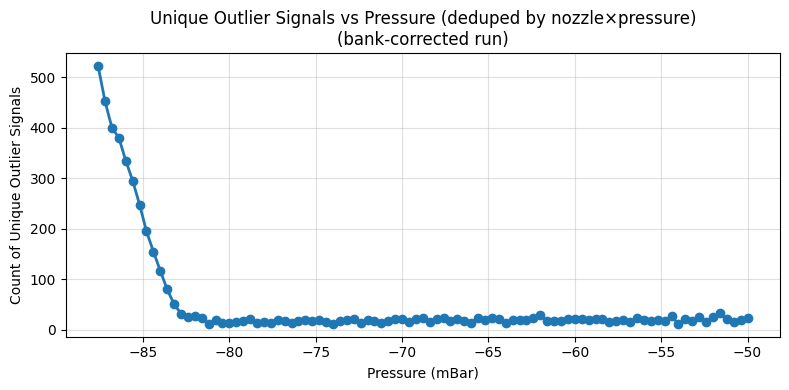

In [ ]:
# --- Summary of outliers by pressure and parameter (BANK.CORRECTED run) ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ---- CONFIG ----
replicate = 1
FIT_DIR   = "/content/drive/MyDrive/data/fit"

# phase-flipped merged file
MERGED_FP = os.path.join(
    FIT_DIR,
    f"merged_rep_{replicate}_lowering_bankcorrected_params6_Q_rmse_nrmse.npz"
)

# bank-corrected outlier CSV
OUTLIER_CSV_FALLBACK = os.path.join(
    FIT_DIR,
    f"outliers_manual_thresholds_rep_{replicate}_lowering_bankcorrected.csv"
)

SMALL_UNIQUE_THRESH = 10  # print pressures with unique_count <= this

# ---- Ensure we have outliers_df ----
try:
    outliers_df
except NameError:
    if os.path.exists(OUTLIER_CSV_FALLBACK):
        outliers_df = pd.read_csv(OUTLIER_CSV_FALLBACK)
        print(f" Loaded outliers_df from {OUTLIER_CSV_FALLBACK}")
    else:
        raise RuntimeError("outliers_df not found in memory and fallback CSV is missing.")

# ---- Load merged to know total counts (nozzles × pressures) ----
try:
    len_nozzles = len(nozzles)
    len_pressures = len(pressures)
except NameError:
    m = np.load(MERGED_FP, allow_pickle=True)
    nozzles   = m["nozzles"]
    pressures = m["pressures"].astype(float)
    len_nozzles   = len(nozzles)
    len_pressures = len(pressures)
    print(f" Loaded nozzles/pressures from {MERGED_FP}")

# Guard: empty table?
if outliers_df.empty:
    print(" outliers_df is empty — nothing to summarize.")
else:
    # Ensure numeric pressure for grouping
    outliers_df["pressure_mBar"] = pd.to_numeric(outliers_df["pressure_mBar"], errors="coerce")

    # --- Outlier counts per pressure (raw, may double count) ---
    outliers_by_pressure = (
        outliers_df.groupby("pressure_mBar", dropna=False)
        .size().reset_index(name="count")
        .sort_values("pressure_mBar")
    )

    # --- Outlier counts per parameter ---
    if "parameter" in outliers_df.columns:
        outliers_by_param = (
            outliers_df.groupby("parameter", dropna=False)
            .size().reset_index(name="count")
            .sort_values("count", ascending=False)
        )
    else:
        outliers_by_param = pd.DataFrame(columns=["parameter","count"])

    # Optional order (include nrmse now)
    desired_order = ["rmse", "nrmse", "A", "tau", "f", "phi", "C", "D"]
    present = [p for p in desired_order if p in outliers_by_param["parameter"].tolist()]
    if present:
        outliers_by_param["parameter"] = pd.Categorical(
            outliers_by_param["parameter"], categories=present, ordered=True
        )
        outliers_by_param = outliers_by_param.sort_values("parameter")

    # --- Fractions ---
    # unique nozzles flagged at least once
    unique_nozzles_flagged = outliers_df["nozzle_idx"].nunique()
    nozzle_fraction = unique_nozzles_flagged / max(1, len_nozzles)

    # unique (nozzle, pressure) pairs flagged
    pair_count = (
        outliers_df[["nozzle_idx", "pressure_idx"]]
        .drop_duplicates()
        .shape[0]
    )
    total_signals = len_nozzles * len_pressures
    pair_fraction = pair_count / max(1, total_signals)

    # --- Display numeric summaries ---
    print("🔹 Outliers by Pressure (count):")
    print(outliers_by_pressure.head(10), "\n")

    print("🔹 Outliers by Parameter (count):")
    print(outliers_by_param, "\n")

    print(f"🔹 Unique nozzles flagged: {unique_nozzles_flagged}/{len_nozzles} "
          f"({nozzle_fraction*100:.2f}%)")
    print(f"🔹 Unique (nozzle × pressure) signals flagged: "
          f"{pair_count}/{total_signals} ({pair_fraction*100:.2f}%)\n")

    # --- Plot : unique (nozzle×pressure) outliers per pressure (simple plot) ---
    dedup_pairs = (
        outliers_df[["nozzle_idx", "pressure_idx", "pressure_mBar"]]
        .drop_duplicates()
        .sort_values(["pressure_mBar", "nozzle_idx", "pressure_idx"])
    )

    unique_by_pressure = (
        dedup_pairs.groupby("pressure_mBar", dropna=False)
        .size().reset_index(name="unique_count")
        .sort_values("pressure_mBar")
    )

    if not unique_by_pressure.empty:
        plt.figure(figsize=(8,4))
        plt.plot(unique_by_pressure["pressure_mBar"], unique_by_pressure["unique_count"], 'o-', lw=2)
        plt.title("Unique Outlier Signals vs Pressure (deduped by nozzle×pressure)\n(bank-corrected run)")
        plt.xlabel("Pressure (mBar)")
        plt.ylabel("Count of Unique Outlier Signals")
        plt.grid(True, alpha=0.4)
        plt.tight_layout()
        plt.show()

        # --- Print small unique-count tail (<= threshold) ---
        tail = unique_by_pressure[unique_by_pressure["unique_count"] <= SMALL_UNIQUE_THRESH]
        if not tail.empty:
            print(f"Pressures with small unique-counts (<= {SMALL_UNIQUE_THRESH}):")
            print(tail.to_string(index=False))


**Interactive Outlier Viewer**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import os, json

# --- Guards & fallbacks ---
if 'outliers_df' not in globals() or outliers_df.empty:
    print(" outliers_df is empty or not defined — nothing to browse.")
else:
    # Ensure indices are integers
    outliers_df["nozzle_idx"]   = outliers_df["nozzle_idx"].astype(int)
    outliers_df["pressure_idx"] = outliers_df["pressure_idx"].astype(int)

    # --- Load merged BANK-CORRECTED fit products if not already in memory ---
    replicate = 1
    FIT_DIR   = "/content/drive/MyDrive/data/fit"
    MERGED_FP = os.path.join(
        FIT_DIR,
        f"merged_rep_{replicate}_lowering_bankcorrected_params6_Q_rmse_nrmse.npz"
    )

    try:
        params6_all
        rmse_all
        nrmse_all
        pressures
        nozzles
        inverted_mask
    except NameError:
        m = np.load(MERGED_FP, allow_pickle=True)
        params6_all    = m["params6_all"]         # (n_nozzles, n_pressures, 6)
        rmse_all       = m["rmse_all"]            # (n_nozzles, n_pressures)
        nrmse_all      = m["nrmse_all"]           # (n_nozzles, n_pressures)
        pressures      = m["pressures"].astype(float)
        nozzles        = m["nozzles"]
        inverted_mask  = m.get("inverted_mask", None)  # bank-based inversion intent
        if inverted_mask is None:
            print(" inverted_mask not found in merged file; assuming no inversion.")
            inverted_mask = np.zeros((params6_all.shape[0], params6_all.shape[1]), dtype=bool)

    # --- Load raw tensor & build timebase if needed ---
    try:
        tensor
        t
    except NameError:
        base_ring   = "/content/drive/MyDrive/data/ringdown"
        tensor_path = os.path.join(base_ring, f"tensor_replicate_{replicate}_lowering_ringdown.npy")
        tensor      = np.load(tensor_path, allow_pickle=True)
        fs          = 4.125e6
        dt          = 1.0 / fs
        n_samples   = tensor.shape[1]
        t           = np.arange(n_samples) * dt

    # --- Deduplicate outlier pairs and collect flagged parameters per pair ---
    unique_outliers = (
        outliers_df.groupby(["nozzle_idx", "pressure_idx"], as_index=False)
        .agg(parameter=("parameter", lambda x: ", ".join(sorted(pd.Series(x).dropna().unique()))))
    )

    outlier_pairs = list(zip(unique_outliers["nozzle_idx"].tolist(),
                             unique_outliers["pressure_idx"].tolist()))
    print(f"Total unique outlier (nozzle × pressure) combinations: {len(outlier_pairs)}")

    # Quick lookup for flagged parameters
    flagged_map = {(int(r.nozzle_idx), int(r.pressure_idx)): r.parameter
                   for _, r in unique_outliers.iterrows()}

    # --- Model with baseline (matches saved params6) ---
    def damped_sine_baseline_tau(t, A, tau, f, phi, C, D):
        # y(t) = C + D*t + A * exp(-t/tau) * sin(2π f t + φ)
        tau = np.clip(tau, 1e-12, None)
        return C + D*t + A*np.exp(-t/tau)*np.sin(2*np.pi*f*t + phi)

    # --- Apply the same reflection used during bank-corrected fitting ---
    def maybe_reflect_for_view(nozzle_idx, pressure_idx, y_raw):
        """
        If this (nozzle, pressure) was inverted in the bank-corrected fit
        (inverted_mask True), reflect y_raw around its mid-value:
        y_mid = (min+max)/2; y' = 2*y_mid - y_raw.
        Otherwise, return y_raw unchanged.
        """
        if inverted_mask[nozzle_idx, pressure_idx]:
            y_min, y_max = y_raw.min(), y_raw.max()
            y_mid = 0.5 * (y_min + y_max)
            return 2*y_mid - y_raw
        else:
            return y_raw

    def show_outlier(index=0):
        """Display measured (possibly inverted) vs fitted for the selected unique outlier."""
        if not outlier_pairs:
            print("No outlier pairs available.")
            return
        if index < 0 or index >= len(outlier_pairs):
            print("Index out of range")
            return

        nozzle_idx, pressure_idx = map(int, outlier_pairs[index])

        # Metadata
        nozzle_name  = nozzles[nozzle_idx]
        pressure_val = pressures[pressure_idx]

        # Measured signal (raw) + bank-corrected view
        y_raw = tensor[nozzle_idx, :, pressure_idx]
        y     = maybe_reflect_for_view(nozzle_idx, pressure_idx, y_raw)

        # Saved params + reconstruction
        A, tau, f, phi, C, D = params6_all[nozzle_idx, pressure_idx, :]
        yhat = damped_sine_baseline_tau(t, A, tau, f, phi, C, D)

        # Metrics: prefer saved ones (they were computed vs the signal used in fitting)
        rmse_saved  = rmse_all[nozzle_idx, pressure_idx]
        nrmse_saved = nrmse_all[nozzle_idx, pressure_idx]

        if np.isfinite(rmse_saved) and np.isfinite(nrmse_saved):
            rmse_val, nrmse_val = float(rmse_saved), float(nrmse_saved)
        else:
            # fallback: recompute vs y (bank-corrected view)
            rmse_val  = float(np.sqrt(np.mean((y - yhat)**2)))
            nrmse_val = float(rmse_val / (np.ptp(y) + 1e-12))

        resid = y - yhat

        # Which parameters flagged this (union)
        param_list = flagged_map.get((nozzle_idx, pressure_idx), "")

        inverted_flag = bool(inverted_mask[nozzle_idx, pressure_idx])

        # --- Console info ---
        print(f"\n Outlier #{index+1}/{len(outlier_pairs)}")
        print(f"🔹 Nozzle index: {nozzle_idx}")
        print(f"🔹 Nozzle ID: {nozzle_name}")
        print(f"🔹 Pressure: {pressure_val:.2f} mBar")
        print(f"🔹 Flagged parameters: {param_list if param_list else '(unknown)'}")
        print(f"🔹 Inverted for fit (bank rule): {inverted_flag}")
        print(f"   A = {A:.2e}, τ = {tau*1e6:.2f} µs, f = {f/1e3:.2f} kHz, φ = {phi:.2f} rad, C = {C:.3g}, D = {D:.3g}")
        print(f"🔹 RMSE = {rmse_val:.4f}, NRMSE = {nrmse_val:.4f}")

        # --- Plot (signal + fit) ---
        plt.figure(figsize=(10, 5))
        plt.plot(t * 1e6, y,    label="Measured (bank-corrected view)", lw=2)
        plt.plot(t * 1e6, yhat, '--', label="Fitted (bank-corrected params6)", lw=2)
        plt.title(
            f"Outlier — Nozzle #{nozzle_idx} ({nozzle_name}) @ {pressure_val:.1f} mBar\n"
            f"RMSE={rmse_val:.3f}, NRMSE={nrmse_val:.3f}, Inverted={inverted_flag}"
        )
        plt.xlabel("Time (µs)")
        plt.ylabel("Amplitude (a.u.)")
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

        # --- Plot residuals ---
        plt.figure(figsize=(10, 3))
        plt.plot(t * 1e6, resid, color='gray')
        plt.title(f"Residuals — Nozzle #{nozzle_idx} ({nozzle_name}) (Inverted={inverted_flag})")
        plt.xlabel("Time (µs)")
        plt.ylabel("Residual")
        plt.grid(True); plt.tight_layout(); plt.show()

    # --- Interactive slider to browse unique outliers ---
    interact(
        show_outlier,
        index=IntSlider(
            min=0,
            max=max(0, len(outlier_pairs) - 1),
            step=1,
            value=0,
            description='Outlier #',
            continuous_update=False
        )
    )


Total unique outlier (nozzle × pressure) combinations: 4829


interactive(children=(IntSlider(value=0, continuous_update=False, description='Outlier #', max=4828), Output()…

**Detect “non-oscillatory” signals automatically**

In [ ]:
"""
# ==== Classify ALL 1280×95 signals: non-oscillatory / oscillatory defect / healthy ====
from scipy.signal import find_peaks, hilbert
from scipy.fft import rfft, rfftfreq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import os

# ---------------- CONFIG ----------------
FS = 4.125e6
TSTART_US = 2.5
BAND = (100e3, 180e3)      # spectral band for ring energy
RING_MIN = 0.10            # fraction of in-band spectral energy
ZC_MAX = 6                 # max zero crossings for non-osc
PK_MAX = 4                 # max |y| peaks for non-osc
TAU_MIN = -8e-6            # τ > -8 µs -> "too slow" decay (combined with low f)
FREQ_MAX = 100e3           # fitted frequency < 100 kHz -> likely capacitive
ENV_DECAY_FRAC = 0.7       # ≥70% of envelope derivative negative

# Manual thresholds for "oscillatory defect" (from your list)
TAU_BOUNDS   = (6e-6, 13e-6)                 # seconds
A_BOUNDS     = (0.0, 1000.0)
F_BOUNDS     = (125_000.0, 175_000.0)        # Hz
PHI_RANGES   = [(0.6, 1.5), (-2.4, -1.55)]   # rad (union)
C_BOUNDS     = (1750.0, 2600.0)
D_RANGES     = [(-1.75, -0.25), (0.3e7, 1.7e7)]
RMSE_BOUNDS  = (20.0, 80.0)

# ---------------- LOAD DATA ----------------
replicate = 1
FIT_DIR   = "/content/drive/MyDrive/data/fit"
MERGED_FP = os.path.join(FIT_DIR, f"merged_rep_{replicate}_lowering_params6_Q_rmse_nrmse.npz")
m = np.load(MERGED_FP, allow_pickle=True)
params6_all = m["params6_all"]           # (N,P,6) [A,tau,f,phi,C,D]
rmse_all    = m["rmse_all"]              # (N,P)
nrmse_all   = m["nrmse_all"]             # (N,P)
pressures   = m["pressures"].astype(float)
nozzles     = m["nozzles"]

N, P, _ = params6_all.shape
print(f" Loaded merged: params6 {params6_all.shape}, rmse {rmse_all.shape}")

# Raw signals + time base
base_ring    = "/content/drive/MyDrive/data/ringdown"
tensor_path  = os.path.join(base_ring, f"tensor_replicate_{replicate}_lowering_ringdown.npy")
tensor       = np.load(tensor_path, allow_pickle=True)  # (N, samples, P)
fs = FS
dt = 1.0 / fs
n_samples = tensor.shape[1]
t = np.arange(n_samples) * dt

# ---------------- Helpers ----------------
def in_any_range(x, ranges):
    mask = np.zeros_like(x, dtype=bool)
    for lo, hi in ranges:
        lo_, hi_ = (min(lo, hi), max(lo, hi))
        mask |= (x >= lo_) & (x <= hi_)
    return mask

def damped_sine_baseline_tau(t, A, tau, f, phi, C, D):
    tau = np.clip(tau, 1e-12, None)
    return C + D*t + A*np.exp(-t/tau)*np.sin(2*np.pi*f*t + phi)

def detect_nonoscillatory(y, fs, A, tau, f_fit):
    """Return (True, diagnostics) if waveform likely non-oscillatory."""
    y = y - np.median(y)
    tt = np.arange(len(y)) / fs
    mask = tt >= (TSTART_US * 1e-6)
    y2 = y[mask]

    # Guard
    if y2.size < 8:
        details = dict(ring_score=np.nan, n_zc=0, n_pk=0, frac_env_down=np.nan, tau=tau, f_fit=f_fit)
        return False, details

    # Spectral energy in band
    try:
        Y = np.abs(rfft(y2))**2
        f = rfftfreq(len(y2), 1/fs)
        total = np.sum(Y) + 1e-12
        inband = (f >= BAND[0]) & (f <= BAND[1])
        ring_score = np.sum(Y[inband]) / total
    except Exception:
        ring_score = np.nan

    # Zero crossings & peaks
    zc = np.where(np.diff(np.sign(y2)) != 0)[0]
    min_dist = max(1, int(fs / (BAND[1] * 2)))
    pk, _ = find_peaks(np.abs(y2), distance=min_dist)
    n_zc, n_pk = len(zc), len(pk)

    # Envelope monotonicity
    try:
        env = np.abs(hilbert(y2))
        denv = np.diff(env)
        frac_down = np.mean(denv < 0) if denv.size else 0.0
    except Exception:
        frac_down = np.nan

    # Physics heuristics
    slow_tau = tau > TAU_MIN
    low_freq = f_fit < FREQ_MAX

    nonosc = (
        (np.isnan(ring_score) or (ring_score < RING_MIN))
        or ((n_zc <= ZC_MAX) and (n_pk <= PK_MAX) and (not np.isnan(frac_down) and frac_down >= ENV_DECAY_FRAC))
        or (slow_tau and low_freq)
    )

    details = dict(ring_score=ring_score, n_zc=n_zc, n_pk=n_pk, frac_env_down=frac_down, tau=tau, f_fit=f_fit)
    return nonosc, details

def is_osc_defect(A, tau, f, phi, C, D, rmse):
    ok_A   = (A   >= A_BOUNDS[0])   & (A   <= A_BOUNDS[1])
    ok_tau = (tau >= TAU_BOUNDS[0]) & (tau <= TAU_BOUNDS[1])
    ok_f   = (f   >= F_BOUNDS[0])   & (f   <= F_BOUNDS[1])
    ok_phi = in_any_range(np.array([phi]), PHI_RANGES)[0]
    ok_C   = (C   >= C_BOUNDS[0])   & (C   <= C_BOUNDS[1])
    ok_D   = in_any_range(np.array([D]),   D_RANGES)[0]
    ok_R   = (rmse >= RMSE_BOUNDS[0]) & (rmse <= RMSE_BOUNDS[1])
    ok_all = ok_A & ok_tau & ok_f & ok_phi & ok_C & ok_D & ok_R
    return not ok_all

# ---------------- Classify all signals ----------------
nonosc_rows = []
oscdef_rows = []
healthy_rows = []

for i in range(N):
    for j in range(P):
        y = tensor[i, :, j]
        A, tau, f_fit, phi, C, D = params6_all[i, j, :]
        rmse = rmse_all[i, j]

        # Non-osc detector
        nonosc, d = detect_nonoscillatory(y, FS, A, tau, f_fit)

        if nonosc:
            nonosc_rows.append({
                "nozzle_idx": i, "nozzle_id": str(nozzles[i]),
                "pressure_idx": j, "pressure_mBar": float(pressures[j]),
                **d, "category": "nonosc"
            })
            continue

        # Oscillatory defect via thresholds
        if is_osc_defect(A, tau, f_fit, phi, C, D, rmse):
            oscdef_rows.append({
                "nozzle_idx": i, "nozzle_id": str(nozzles[i]),
                "pressure_idx": j, "pressure_mBar": float(pressures[j]),
                "A": A, "tau": tau, "f": f_fit, "phi": phi, "C": C, "D": D, "rmse": rmse,
                "category": "osc_defect"
            })
        else:
            healthy_rows.append((i, j))

nonosc_df  = pd.DataFrame(nonosc_rows)
oscdef_df  = pd.DataFrame(oscdef_rows)
healthy_pairs = healthy_rows

print(f"⚡ Non-oscillatory detected: {len(nonosc_df)}")

# ---------------- Interactive viewers ----------------
def view_pair(i, j, title_prefix):
    nozzle_name  = nozzles[i]
    pressure_val = pressures[j]
    y = tensor[i, :, j]
    A, tau, f_fit, phi, C, D = params6_all[i, j, :]
    yhat = damped_sine_baseline_tau(t, A, tau, f_fit, phi, C, D)
    rmse_val  = rmse_all[i, j]
    nrmse_val = nrmse_all[i, j]
    plt.figure(figsize=(10,5))
    plt.plot(t*1e6, y, label="Measured", lw=2)
    plt.plot(t*1e6, yhat, '--', label="Fitted", lw=2)
    plt.axvspan(0, TSTART_US, color='orange', alpha=0.1, label=f"Ignored first {TSTART_US} µs")
    plt.title(f"{title_prefix} — Nozzle #{i} ({nozzle_name}) @ {pressure_val:.1f} mBar\n"
              f"A={A:.2e}, τ={tau*1e6:.2f} µs, f={f_fit/1e3:.2f} kHz, φ={phi:.2f}, C={C:.3g}, D={D:.3g} | "
              f"RMSE={rmse_val:.3f}, NRMSE={nrmse_val:.3f}")
    plt.xlabel("Time (µs)"); plt.ylabel("Amplitude (a.u.)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Non-osc viewer
nonosc_pairs = list(zip(nonosc_df["nozzle_idx"], nonosc_df["pressure_idx"])) if not nonosc_df.empty else []
if nonosc_pairs:
    print("\n Explore non-oscillatory waveforms:")
    def show_nonosc(idx=0):
        i, j = map(int, nonosc_pairs[idx])
        view_pair(i, j, "Non-oscillatory")
    interact(show_nonosc, idx=IntSlider(min=0, max=len(nonosc_pairs)-1, step=1, value=0,
                                        description="NonOsc #", continuous_update=False))
else:
    print("\n No non-oscillatory signals with current heuristics.")
"""

SyntaxError: unterminated triple-quoted string literal (detected at line 194) (ipython-input-4118741428.py, line 67)

**Calculated features**

In [ ]:
"""
# ==== Fast features on RAW signal (post-transient) for ALL signals ====
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, gmean
from scipy.signal import welch, hilbert
from scipy.fft import dct, rfft, rfftfreq
from tqdm.auto import tqdm
import json, os

# --- safe Tukey import (fallback to Hann if unavailable) ---
try:
    from scipy.signal.windows import tukey as _tukey
    def tukey(n, alpha=0.1):
        return _tukey(n, alpha) if n > 1 else np.ones(n)
except Exception:
    def tukey(n, alpha=0.1):
        if n <= 1: return np.ones(n)
        return np.hanning(n)

# ---- CONFIG ----
replicate   = 1
variant     = "lowering"
base_pre    = "/content/drive/MyDrive/data/preprocessed"
base_ring   = "/content/drive/MyDrive/data/ringdown"
out_dir     = "/content/drive/MyDrive/data/fit"

fs          = 4.125e6          # Hz
ignore_us   = 2.5              # ignore first X µs (capacitive lobe)
n_windows   = 4
dct_k       = 12
band_edges  = (0, 80e3, 200e3, 600e3, 1.5e6)

os.makedirs(out_dir, exist_ok=True)

# ---- LOAD ----
tensor_path = os.path.join(base_ring, f"tensor_replicate_{replicate}_{variant}_ringdown.npy")
press_path  = os.path.join(base_pre,  f"pressures_replicate_{replicate}_{variant}.json")
nozz_path   = os.path.join(base_pre,  f"nozzles_replicate_{replicate}_{variant}.json")

tensor = np.load(tensor_path, allow_pickle=True)                  # (N, T, K)
with open(press_path, "r") as f: pressures = np.array(json.load(f), dtype=float)  # (K,)
with open(nozz_path, "r") as f: nozzles = json.load(f)                            # (N,)

N, T, K = tensor.shape
print(f"Tensor: {N} × {T} × {K}  (nozzles × samples × pressures)")

# ---- helpers ----
def window_indices(Tlen, n_windows):
    L = max(1, Tlen // n_windows)
    return [(i*L, min((i+1)*L, Tlen)) for i in range(n_windows)]

def feats_time(seg):
    seg = seg.astype(float)
    if seg.size == 0:
        return np.zeros(9)
    seg = seg - np.mean(seg)
    eps = 1e-12
    return np.array([
        seg.mean(), seg.std(), np.sqrt(np.mean(seg**2)),             # mean, std, RMS
        seg.max()-seg.min(), np.max(np.abs(seg)),                    # peak-to-peak, abs-peak
        skew(seg, bias=False) if seg.size > 2 else 0.0,
        kurtosis(seg, fisher=True, bias=False) if seg.size > 3 else 0.0,
        np.sum(np.abs(seg)),                                         # |area|
        np.count_nonzero(np.diff(np.sign(seg))) / (len(seg)+eps)     # zero-crossing rate
    ])

def spectral_flatness(p):
    p = np.asarray(p, float) + 1e-18
    return float(gmean(p) / (np.mean(p) + 1e-18))

def feats_freq(x, fs, edges):
    if x.size < 8:
        return np.concatenate([[0, 0, 0, 0], np.zeros(len(edges)-1)])
    w = tukey(len(x), 0.1)
    nper = max(8, min(len(x), 256))  # guard for Welch length
    f, Pxx = welch(x*w, fs=fs, nperseg=nper, noverlap=0)
    Pxx = Pxx + 1e-18
    P = Pxx / Pxx.sum()
    centroid = float(np.sum(P * f))
    domf = float(f[np.argmax(Pxx)]) if f.size else 0.0
    bands = []
    for lo, hi in zip(edges[:-1], edges[1:]):
        m = (f>=lo) & (f<hi)
        bands.append(float(P[m].sum()))
    ent = float(-np.sum(P * np.log(P)))
    flat = spectral_flatness(Pxx)
    return np.concatenate([[centroid, domf, ent, flat], np.array(bands)])

def feats_envelope(x, fs):
    if x.size < 8:
        return np.array([0,0,0,0,0], float)
    env = np.abs(hilbert(x)) + 1e-12
    t = np.arange(len(x))/fs
    try:
        m, _ = np.polyfit(t, np.log(env), 1)          # log-envelope slope ≈ -1/τ
    except Exception:
        m = 0.0
    t_peak = float(t[np.argmax(env)]) if len(env) else 0.0
    q1 = int(0.1*len(env)); q9 = int(0.9*len(env))
    if q1 == 0: q1 = 1
    num = np.mean(env[q9:]) if q9 < len(env) else env[-1]
    den = np.mean(env[q1:q1+max(1, q1)])
    decay_ratio = float(num / (den + 1e-18))
    return np.array([float(env.mean()), float(env.std()), float(m), t_peak, decay_ratio])

def feats_periodicity(x, fs):
    x = x - np.mean(x)
    if x.size < 8:
        return np.array([0.0, 0.0], float)
    # autocorr
    ac = np.correlate(x, x, mode='full')[len(x)-1:]
    ac = ac / (ac[0] + 1e-18)
    lag_min = max(1, int(fs/400e3))     # ~ >2.5 µs period upper bound safeguard
    lag_max = min(len(ac)-1, int(fs/40e3))
    if lag_max <= lag_min:
        return np.array([0.0, 0.0], float)
    lag = int(np.argmax(ac[lag_min:lag_max]) + lag_min)
    t_ac_peak = lag / fs
    # cepstrum
    S = np.abs(rfft(x)) + 1e-18
    logS = np.log(S)
    cep = np.abs(np.fft.irfft(logS))
    if cep.size <= lag_min:
        t_cep_peak = 0.0
    else:
        q = int(np.argmax(cep[lag_min:min(lag_max, len(cep))]) + lag_min)
        t_cep_peak = q / fs
    return np.array([float(t_ac_peak), float(t_cep_peak)])

def extract_fast(x, fs, ignore_us, band_edges, n_windows, dct_k):
    x = np.asarray(x, float)
    x = x - np.median(x)  # detrend
    t = np.arange(len(x))/fs
    post = t >= (ignore_us*1e-6)
    x2 = x[post] if np.any(post) else x

    feats = []
    # windowed time features on post-transient
    for a,b in window_indices(len(x2), n_windows):
        feats.append(feats_time(x2[a:b]))
    feats = np.concatenate(feats) if len(feats) else np.zeros(9*n_windows)

    # spectral features on post-transient
    feats = np.concatenate([feats, feats_freq(x2, fs, band_edges)])

    # envelope features
    feats = np.concatenate([feats, feats_envelope(x2, fs)])

    # periodicity (autocorr/cepstrum)
    feats = np.concatenate([feats, feats_periodicity(x2, fs)])

    # low-order DCT of post-transient
    if x2.size >= 2:
        feats = np.concatenate([feats, dct(x2, type=2, norm='ortho')[:dct_k]])
    else:
        feats = np.concatenate([feats, np.zeros(dct_k)])

    # ensure finite
    feats = np.nan_to_num(feats, nan=0.0, posinf=0.0, neginf=0.0)
    return feats

# ---- column names ----
time_names = [f"W{w}_{n}" for w in range(n_windows) for n in
              ["mean","std","rms","p2p","absmax","skew","kurt","absarea","zcr"]]
freq_names = ["spec_centroid","dom_freq","spec_entropy","spec_flatness"] + [f"band_{i}" for i in range(len(band_edges)-1)]
env_names  = ["env_mean","env_std","log_env_slope","t_env_peak","env_decay_ratio"]
per_names  = ["t_ac_peak","t_cep_peak"]
dct_names  = [f"dct_{i}" for i in range(dct_k)]
colnames   = ["Nozzle","Pressure_mBar","NozzleIdx","PressureIdx"] + \
             time_names + freq_names + env_names + per_names + dct_names

# ---- extract over ALL signals ----
rows = []
for i in tqdm(range(N), desc="Nozzles"):
    for k in range(K):
        x = tensor[i, :, k]
        feats = extract_fast(x, fs, ignore_us, band_edges, n_windows, dct_k)
        rows.append([nozzles[i], float(pressures[k]), i, k, *feats])

fast_df = pd.DataFrame(rows, columns=colnames)
print(f" Fast features: {fast_df.shape[0]} × {fast_df.shape[1]}")

# ---- save ----
out_fast = os.path.join(out_dir, f"fast_features_rep_{replicate}_{variant}_raw.csv")
fast_df.to_csv(out_fast, index=False)
print(" Saved:", out_fast)

fast_df.head(2)
"""


**Features boxplots**

✅ Merged NPZ loaded: N=1280, P=95, params6=(1280, 95, 6)
ℹ️ Using outliers_df from memory.
🔹 Unique outlier pairs (manual thresholds): 4829
✅ Label counts:
 Label
healthy    116771
outlier      4829
Name: count, dtype: int64
✅ Bank column added from nozzle IDs (A–D)
✅ Using subset of healthy/outlier: 121600 signals
✅ Fitted-parameter features available: ['fit_A', 'fit_tau', 'fit_f', 'fit_phi', 'fit_C', 'fit_D', 'fit_Q', 'fit_rmse']


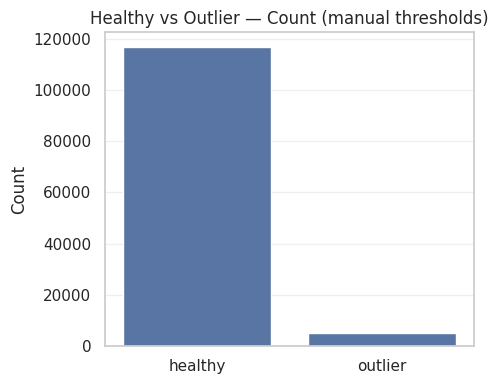

interactive(children=(Dropdown(description='Feature:', options=('fit_A', 'fit_tau', 'fit_f', 'fit_phi', 'fit_C…

In [ ]:
# ==== Boxplots: fitted params only, split into Healthy vs Outlier ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Dropdown
import os

sns.set(style="whitegrid")

# ---------------- Paths / config ----------------
replicate = 1
variant   = "lowering"

FIT_DIR      = "/content/drive/MyDrive/data/fit"
# use BANK-CORRECTED merged file
MERGED_FP    = os.path.join(FIT_DIR, f"merged_rep_{replicate}_lowering_bankcorrected_params6_Q_rmse_nrmse.npz")
OUTLIER_CSV  = os.path.join(FIT_DIR, f"outliers_manual_thresholds_rep_{replicate}_{variant}.csv")

# ---------------- Load merged (get N, P, and the 6 params) ----------------
if not os.path.exists(MERGED_FP):
    raise FileNotFoundError(f"Missing merged NPZ: {MERGED_FP}")

m = np.load(MERGED_FP, allow_pickle=True)
pressures    = m["pressures"].astype(float)
nozzles      = m["nozzles"]
params6_all  = m["params6_all"]   # (N, P, 6) -> [A, tau, f, phi, C, D]
rmse_all     = m["rmse_all"]      # (N, P)
N, P, _ = params6_all.shape
print(f" Merged NPZ loaded: N={N}, P={P}, params6={params6_all.shape}")

# ---------------- Build a tidy DataFrame of fitted params ----------------
# Flatten (N,P,*) -> (N*P,*)
idx = pd.MultiIndex.from_product([range(N), range(P)], names=["NozzleIdx","PressureIdx"])
p6_flat  = params6_all.reshape(-1, 6)
rm_flat  = rmse_all.reshape(-1)

param_df = pd.DataFrame(p6_flat, columns=["fit_A","fit_tau","fit_f","fit_phi","fit_C","fit_D"])
param_df["fit_rmse"] = rm_flat
param_df["NozzleIdx"]   = idx.get_level_values("NozzleIdx").astype(int)
param_df["PressureIdx"] = idx.get_level_values("PressureIdx").astype(int)

# optional: derived Q
param_df["fit_Q"] = np.pi * param_df["fit_f"] * param_df["fit_tau"]

# attach actual nozzle label and pressure (not strictly needed for boxplots)
param_df["NozzleID"]     = param_df["NozzleIdx"].apply(lambda i: nozzles[i])
param_df["Pressure_mBar"] = param_df["PressureIdx"].apply(lambda j: pressures[j])

# ---------------- Load/prepare manual outliers ----------------
try:
    outliers_df  # already in memory
    if not isinstance(outliers_df, pd.DataFrame):
        raise NameError
    print(" Using outliers_df from memory.")
except Exception:
    if not os.path.exists(OUTLIER_CSV):
        raise FileNotFoundError(f"Manual outlier CSV not found:\n{OUTLIER_CSV}")
    outliers_df = pd.read_csv(OUTLIER_CSV)
    print(f" Loaded manual outliers: {OUTLIER_CSV}  ({len(outliers_df)} rows)")

# Ensure proper dtypes
for col in ("nozzle_idx","pressure_idx"):
    outliers_df[col] = pd.to_numeric(outliers_df[col], errors="coerce").astype("Int64")

# Unique (nozzle, pressure) pairs flagged by ANY parameter
pair_set = set(
    (int(i), int(j))
    for i, j in outliers_df[["nozzle_idx","pressure_idx"]].dropna().astype(int).to_records(index=False)
)
print(f"🔹 Unique outlier pairs (manual thresholds): {len(pair_set)}")

# ---------------- Attach Label: outlier vs healthy ----------------
def label_from_pairs(row):
    i, j = int(row["NozzleIdx"]), int(row["PressureIdx"])
    if 0 <= i < N and 0 <= j < P:
        return "outlier" if (i, j) in pair_set else "healthy"
    return np.nan

param_df["Label"] = param_df.apply(label_from_pairs, axis=1)
print(" Label counts:\n", param_df["Label"].value_counts(dropna=False))

# ---------------- Add BANK (A/B/C/D) from nozzle name ----------------
def assign_bank_from_name(nozzle_id) -> str:
    s = str(nozzle_id)
    return s[0].upper() if s else "?"

param_df["Bank"] = param_df["NozzleID"].apply(assign_bank_from_name)
print(" Bank column added from nozzle IDs (A–D)")

# ---------------- Subset to healthy/outlier only ----------------
subset_df = param_df.query("Label in ['healthy','outlier']").copy()
print(f" Using subset of healthy/outlier: {subset_df.shape[0]} signals")

# ---------------- Features: fitted params only ----------------
feature_cols = ["fit_A", "fit_tau", "fit_f", "fit_phi", "fit_C", "fit_D", "fit_Q", "fit_rmse"]
feature_cols = [f for f in feature_cols if f in subset_df.columns]
print(f" Fitted-parameter features available: {feature_cols}")

# ---------------- Class balance ----------------
plt.figure(figsize=(5,4))
sns.countplot(data=subset_df, x="Label", order=["healthy","outlier"])
plt.title("Healthy vs Outlier — Count (manual thresholds)")
plt.ylabel("Count"); plt.xlabel("")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()

# ---------------- Interactive boxplot ----------------
def plot_feature_boxplot(feature, bank):
    dfp = subset_df[subset_df["Bank"] == bank]
    if dfp.empty:
        print(f"No data for Bank {bank}.")
        return
    plt.figure(figsize=(8,5))
    sns.boxplot(
        data=dfp,
        x="Label",
        y=feature,
        order=["healthy","outlier"],
        showfliers=False,
    )
    plt.title(f"{feature} — Bank {bank}  (Healthy vs Outlier)")
    plt.ylabel(feature); plt.xlabel("")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout(); plt.show()

if feature_cols:
    interact(
        plot_feature_boxplot,
        feature=Dropdown(options=feature_cols,
                         value="fit_A" if "fit_A" in feature_cols else feature_cols[0],
                         description="Feature:"),
        bank=Dropdown(options=["A","B","C","D"], value="A", description="Bank:")
    )
else:
    print(" No fitted-parameter features available to visualize.")




In [ ]:
# ==== Boxplots: fitted params only, split by 3 pressure ranges (all signals) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
import os

# clean matplotlib style
plt.style.use("default")

# ---------------- Paths / config ----------------
replicate = 1
variant   = "lowering"

FIT_DIR      = "/content/drive/MyDrive/data/fit"
MERGED_FP    = os.path.join(FIT_DIR, f"merged_rep_{replicate}_lowering_bankcorrected_params6_Q_rmse_nrmse.npz")

# ---------------- Load merged (get N, P, and the 6 params) ----------------
if not os.path.exists(MERGED_FP):
    raise FileNotFoundError(f"Missing merged NPZ: {MERGED_FP}")

m = np.load(MERGED_FP, allow_pickle=True)
pressures    = m["pressures"].astype(float)    # (P,)
nozzles      = m["nozzles"]
params6_all  = m["params6_all"]   # (N, P, 6) -> [A, tau, f, phi, C, D]
rmse_all     = m["rmse_all"]      # (N, P)

N, P, _ = params6_all.shape
print(f" Merged NPZ loaded: N={N}, P={P}, params6={params6_all.shape}")

# ---------------- Build a tidy DataFrame of fitted params ----------------
idx = pd.MultiIndex.from_product([range(N), range(P)], names=["NozzleIdx","PressureIdx"])
p6_flat  = params6_all.reshape(-1, 6)
rm_flat  = rmse_all.reshape(-1)

param_df = pd.DataFrame(p6_flat, columns=["fit_A","fit_tau","fit_f","fit_phi","fit_C","fit_D"])
param_df["fit_rmse"] = rm_flat
param_df["NozzleIdx"]   = idx.get_level_values("NozzleIdx").astype(int)
param_df["PressureIdx"] = idx.get_level_values("PressureIdx").astype(int)

# derived Q
param_df["fit_Q"] = np.pi * param_df["fit_f"] * param_df["fit_tau"]

# attach actual pressure values
param_df["Pressure_mBar"] = param_df["PressureIdx"].apply(lambda j: pressures[j])

# ---------------- Define pressure bins (3 ranges) ----------------
# thresholds
T1 = -80.8
T2 = -72.0

def pressure_bin(p):
    if p <= T1:
        return f"≤ {T1} mBar"
    elif p <= T2:
        return f"({T1}, {T2}] mBar"
    else:
        return f"> {T2} mBar"

param_df["PressureBin"] = param_df["Pressure_mBar"].apply(pressure_bin)

bin_labels = [f"≤ {T1} mBar", f"({T1}, {T2}] mBar", f"> {T2} mBar"]

# ---------------- Features: fitted params only ----------------
feature_cols = ["fit_A", "fit_tau", "fit_f", "fit_phi", "fit_C", "fit_D", "fit_Q", "fit_rmse"]
feature_cols = [f for f in feature_cols if f in param_df.columns]
print(f" Fitted-parameter features available: {feature_cols}")

# ---------------- Boxplot function ----------------
def plot_feature_by_pressure_bin(feature):
    plt.figure(figsize=(8,5))

    data = [
        param_df.loc[param_df["PressureBin"] == b, feature].dropna().values
        for b in bin_labels
    ]

    # handle bins with no data
    non_empty_labels = [lab for lab, arr in zip(bin_labels, data) if len(arr) > 0]
    non_empty_data   = [arr for arr in data if len(arr) > 0]

    if not non_empty_data:
        print(" No data in any pressure bin.")
        plt.close()
        return

    bp = plt.boxplot(
        non_empty_data,
        labels=non_empty_labels,
        patch_artist=True,
        showfliers=False
    )

    # set everything to regular blue
    for box in bp["boxes"]:
        box.set(facecolor="blue", alpha=0.4, edgecolor="blue", linewidth=1.5)
    for whisker in bp["whiskers"]:
        whisker.set(color="blue", linewidth=1.2)
    for cap in bp["caps"]:
        cap.set(color="blue", linewidth=1.2)
    for median in bp["medians"]:
        median.set(color="blue", linewidth=1.5)

    plt.ylabel(feature)
    plt.xlabel("Pressure ranges (mBar)")
    plt.title(f"{feature} — distribution across 3 pressure ranges\n(all nozzle × pressure pairs)")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

if feature_cols:
    interact(
        plot_feature_by_pressure_bin,
        feature=Dropdown(
            options=feature_cols,
            value="fit_A" if "fit_A" in feature_cols else feature_cols[0],
            description="Parameter:"
        )
    )
else:
    print(" No fitted-parameter features available to visualize.")


✅ Merged NPZ loaded: N=1280, P=95, params6=(1280, 95, 6)
✅ Fitted-parameter features available: ['fit_A', 'fit_tau', 'fit_f', 'fit_phi', 'fit_C', 'fit_D', 'fit_Q', 'fit_rmse']


interactive(children=(Dropdown(description='Parameter:', options=('fit_A', 'fit_tau', 'fit_f', 'fit_phi', 'fit…

**Feature in function of the pressure**

In [ ]:
# --- Interactive Fitted-Param vs Pressure Viewer (BANK-CORRECTED only) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown
import json, os, glob

# --- CONFIG ---
replicate = 1
variant   = "lowering"

FIT_DIR    = "/content/drive/MyDrive/data/fit"
PREP_DIR   = "/content/drive/MyDrive/data/preprocessed"

# bank-corrected merged filename
MERGED_FP   = os.path.join(
    FIT_DIR,
    f"merged_rep_{replicate}_{variant}_bankcorrected_params6_Q_rmse_nrmse.npz"
)
PRESS_JSON  = os.path.join(PREP_DIR, f"pressures_replicate_{replicate}_{variant}.json")
NOZZ_JSON   = os.path.join(PREP_DIR, f"nozzles_replicate_{replicate}_{variant}.json")

# Fallback: auto-discover a bank-corrected merged file if the expected one isn't there
if not os.path.exists(MERGED_FP):
    candidates = sorted(
        glob.glob(os.path.join(
            FIT_DIR,
            f"merged_rep_{replicate}_{variant}_*bankcorrected*params6_Q_rmse_nrmse.npz"
        )),
        key=os.path.getmtime, reverse=True
    )
    if not candidates:
        candidates = sorted(
            glob.glob(os.path.join(FIT_DIR, f"merged_rep_{replicate}_*params6_Q_rmse_nrmse.npz")),
            key=os.path.getmtime, reverse=True
        )
    if not candidates:
        raise FileNotFoundError(
            f"Bank-corrected merged NPZ not found:\n{MERGED_FP}\n"
            f"Also couldn't find any suitable merged_rep_{replicate}_*params6_Q_rmse_nrmse.npz in {FIT_DIR}"
        )
    MERGED_FP = candidates[0]
    print(f" Using discovered merged file: {MERGED_FP}")

# --- LOAD DATA ---
with open(PRESS_JSON) as f: pressures = np.array(json.load(f), dtype=float)
with open(NOZZ_JSON)  as f: nozzles  = json.load(f)

m = np.load(MERGED_FP, allow_pickle=True)
params6 = m["params6_all"]    # (N,P,6) -> [A, tau, f, phi, C, D]
rmse    = m["rmse_all"]       # (N,P)
nrmse   = m["nrmse_all"]      # (N,P)
Q       = m["Q_all"]          # (N,P)

N, P, _ = params6.shape

print(f" Nozzles: {len(nozzles)}, Pressures: {len(pressures)} | params6: {params6.shape}")
print(f" BANK-CORRECTED merged NPZ: {MERGED_FP}")

# sort pressures (ascending) and remember order
order_npz = np.argsort(pressures)
p_sorted  = pressures[order_npz]

# --- Fitted-parameter options ---
fit_options = [
    "A (a.u.)",
    "tau (µs)",
    "f (kHz)",
    "phi (rad)",
    "C",
    "D",
    "RMSE",
    "NRMSE",
    "Q (π f τ)"
]

def _get_fit_series(nozzle_idx, label):
    if label.startswith("A "):
        y = params6[nozzle_idx, :, 0]; ylab = "A (a.u.)"
    elif label.startswith("tau"):
        y = params6[nozzle_idx, :, 1] * 1e6; ylab = "τ (µs)"
    elif label.startswith("f "):
        y = params6[nozzle_idx, :, 2] * 1e-3; ylab = "Frequency (kHz)"
    elif label.startswith("phi"):
        y = params6[nozzle_idx, :, 3]; ylab = "Phase (rad)"
    elif label == "C":
        y = params6[nozzle_idx, :, 4]; ylab = "C"
    elif label == "D":
        y = params6[nozzle_idx, :, 5]; ylab = "D"
    elif label == "RMSE":
        y = rmse[nozzle_idx, :]; ylab = "RMSE"
    elif label == "NRMSE":
        y = nrmse[nozzle_idx, :]; ylab = "NRMSE"
    elif label.startswith("Q"):
        y = Q[nozzle_idx, :]; ylab = "Q (π f τ)"
    else:
        raise ValueError("Unknown fitted-parameter option")
    return y, ylab

def plot_param_vs_pressure(nozzle_idx=0, feature=fit_options[0]):
    # series for this nozzle
    y_all, y_label = _get_fit_series(nozzle_idx, feature)
    y_sorted = y_all[order_npz]

    plt.figure(figsize=(8,5))
    plt.plot(p_sorted, y_sorted, "o-", lw=2)
    plt.title(f"Nozzle #{nozzle_idx} ({nozzles[nozzle_idx]}) — {feature} vs Pressure")
    plt.xlabel("Pressure (mBar)")
    plt.ylabel(y_label)
    plt.grid(True)
    # lowering experiment: often nicer to see high -> low
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()

interact(
    plot_param_vs_pressure,
    nozzle_idx=IntSlider(value=0, min=0, max=len(nozzles)-1, step=1,
                         description="Nozzle:", continuous_update=False),
    feature=Dropdown(options=fit_options, value=fit_options[0], description="Parameter:")
)


✅ Nozzles: 1280, Pressures: 95 | params6: (1280, 95, 6)
✅ BANK-CORRECTED merged NPZ: /content/drive/MyDrive/data/fit/merged_rep_1_lowering_bankcorrected_params6_Q_rmse_nrmse.npz


interactive(children=(IntSlider(value=0, continuous_update=False, description='Nozzle:', max=1279), Dropdown(d…

<function __main__.plot_param_vs_pressure(nozzle_idx=0, feature='A (a.u.)')>

**Selected outliers**

In [ ]:
# --- Focused Viewer: Fitted Parameter vs Pressure (BANK-CORRECTED only) ---
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
import json, os, glob

# --- CONFIG ---
replicate = 1
variant   = "lowering"

FIT_DIR   = "/content/drive/MyDrive/data/fit"
PREP_DIR  = "/content/drive/MyDrive/data/preprocessed"

# BANK-CORRECTED merged file
MERGED_FP   = os.path.join(
    FIT_DIR,
    f"merged_rep_{replicate}_{variant}_bankcorrected_params6_Q_rmse_nrmse.npz"
)
PRESS_JSON  = os.path.join(PREP_DIR, f"pressures_replicate_{replicate}_{variant}.json")
NOZZ_JSON   = os.path.join(PREP_DIR, f"nozzles_replicate_{replicate}_{variant}.json")

# Fallback: auto-discover merged file if the expected one isn't there
if not os.path.exists(MERGED_FP):
    candidates = sorted(
        glob.glob(os.path.join(
            FIT_DIR,
            f"merged_rep_{replicate}_{variant}_*bankcorrected*params6_Q_rmse_nrmse.npz"
        )),
        key=os.path.getmtime, reverse=True
    )
    if not candidates:
        candidates = sorted(
            glob.glob(os.path.join(FIT_DIR, f"merged_rep_{replicate}_*params6_Q_rmse_nrmse.npz")),
            key=os.path.getmtime, reverse=True
        )
    if not candidates:
        raise FileNotFoundError(
            f"Bank-corrected merged NPZ not found:\n{MERGED_FP}\n"
            f"Also couldn't find any merged_rep_{replicate}_*params6_Q_rmse_nrmse.npz in {FIT_DIR}"
        )
    MERGED_FP = candidates[0]
    print(f" Using discovered merged file: {MERGED_FP}")

# --- LOAD DATA ---
with open(PRESS_JSON) as f: pressures = np.array(json.load(f), dtype=float)
with open(NOZZ_JSON)  as f: nozzles  = json.load(f)

m       = np.load(MERGED_FP, allow_pickle=True)
params6 = m["params6_all"]    # (N,P,6) -> [A, tau, f, phi, C, D]
rmse    = m["rmse_all"]       # (N,P)
nrmse   = m["nrmse_all"]      # (N,P)
Q       = m["Q_all"]          # (N,P)

N, P, _ = params6.shape
print(f"✅ Nozzles: {len(nozzles)}, Pressures: {len(pressures)} | params6: {params6.shape}")

# --- fitted-parameter options only ---
param_options = [
    "A (a.u.)",
    "tau (µs)",
    "f (kHz)",
    "phi (rad)",
    "C",
    "D",
    "RMSE",
    "NRMSE",
    "Q (π f τ)"
]

# --- focus nozzles (by ID) ---
focus_nozzles = [
    "A84", "A240", "B65", "B137", "B199", "C149", "C291", "D48", "D257",
    "A163", "A164", "A83", "A211",
    "B255", "B256", "B162", "B15", "B2",
    "C183", "C156", "C133", "C132", "C212", "C1",
    "D244"
]
focus_indices = [i for i, nz in enumerate(nozzles) if nz in focus_nozzles]
if not focus_indices:
    focus_indices = list(range(min(9, len(nozzles))))

# --- failure points (mBar) ---
failure_points = {
    "A84" : -82,   "A240" : -86.4, "B65" : -87.2, "B137" : -86.8, "B199" : -84,
    "C149": -83.2, "C291" : -83.6, "D48" : -85.2, "D257" : -83.6, "A163" : -82.4,
    "A164" : -82.4, "A83" : -82.4, "A211" : -82.8, "B255" : -83.2,
    "B256": -83.2, "C183" : -83.2, "B162" : -83.2, "B15" : -83.2, "C156" : -83.6,
    "C133" : -83.6, "C132" : -83.6, "C212" : -83.6, "D244" : -83.6,
    "B2": -83.6, "C1" : -83.6
}


# sort pressures once for nicer plots
order_p  = np.argsort(pressures)
p_sorted = pressures[order_p]

def _get_fit_series(nozzle_idx, selection):
    if selection.startswith("A "):
        y = params6[nozzle_idx, :, 0]; ylab = "A (a.u.)"
    elif selection.startswith("tau"):
        y = params6[nozzle_idx, :, 1] * 1e6; ylab = "τ (µs)"
    elif selection.startswith("f "):
        y = params6[nozzle_idx, :, 2] * 1e-3; ylab = "Frequency (kHz)"
    elif selection.startswith("phi"):
        y = params6[nozzle_idx, :, 3]; ylab = "Phase (rad)"
    elif selection == "C":
        y = params6[nozzle_idx, :, 4]; ylab = "C"
    elif selection == "D":
        y = params6[nozzle_idx, :, 5]; ylab = "D"
    elif selection == "RMSE":
        y = rmse[nozzle_idx, :]; ylab = "RMSE"
    elif selection == "NRMSE":
        y = nrmse[nozzle_idx, :]; ylab = "NRMSE"
    elif selection.startswith("Q"):
        y = Q[nozzle_idx, :]; ylab = "Q (π f τ)"
    else:
        raise ValueError("Unknown parameter selection.")
    return y, ylab

def plot_selected(nozzle_idx=focus_indices[0], selection=param_options[0]):
    nozzle_id = nozzles[nozzle_idx]

    y_all, y_label = _get_fit_series(nozzle_idx, selection)
    y_sorted = y_all[order_p]

    plt.figure(figsize=(9,5))
    plt.plot(p_sorted, y_sorted, "o-", lw=2, label=f"{nozzle_id}")
    plt.title(f"Nozzle {nozzle_id} — {selection} vs Pressure")
    plt.xlabel("Pressure (mBar)")
    plt.ylabel(y_label)
    plt.grid(True)

    # flip x-axis so high pressure on left (lowering experiment)
    plt.gca().invert_xaxis()

    # failure marker
    if nozzle_id in failure_points:
        fail_p = failure_points[nozzle_id]
        plt.axvline(fail_p, color='r', linestyle='--', lw=2, label=f"Failure @ {fail_p:.1f} mBar")

    plt.legend()
    plt.tight_layout()
    plt.show()

# --- widgets ---
interact(
    plot_selected,
    nozzle_idx=Dropdown(
        options=[(nozzles[i], i) for i in focus_indices],
        value=focus_indices[0],
        description="Nozzle:"
    ),
    selection=Dropdown(
        options=param_options,
        value=param_options[0],
        description="Parameter:"
    )
)



✅ Nozzles: 1280, Pressures: 95 | params6: (1280, 95, 6)


interactive(children=(Dropdown(description='Nozzle:', options=(('A83', 82), ('A84', 83), ('A163', 162), ('A164…

<function __main__.plot_selected(nozzle_idx=82, selection='A (a.u.)')>

In [ ]:
# === Focus-nozzle boxplots (standardized style, incl. RMSE/NRMSE/Q) ===
import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

# clean matplotlib style
plt.style.use("default")

# ---------------- CONFIG & PATHS ----------------
replicate = 1
variant   = "lowering"

FIT_DIR   = "/content/drive/MyDrive/data/fit"
PREP_DIR  = "/content/drive/MyDrive/data/preprocessed"

MERGED_FP  = os.path.join(
    FIT_DIR,
    f"merged_rep_{replicate}_{variant}_bankcorrected_params6_Q_rmse_nrmse.npz"
)
PRESS_JSON = os.path.join(PREP_DIR, f"pressures_replicate_{replicate}_{variant}.json")
NOZZ_JSON  = os.path.join(PREP_DIR, f"nozzles_replicate_{replicate}_{variant}.json")

# Fallback: auto-discover merged file if the expected one isn't there
if not os.path.exists(MERGED_FP):
    candidates = sorted(
        glob.glob(os.path.join(
            FIT_DIR,
            f"merged_rep_{replicate}_{variant}_*bankcorrected*params6_Q_rmse_nrmse.npz"
        )),
        key=os.path.getmtime, reverse=True
    )
    if not candidates:
        candidates = sorted(
            glob.glob(os.path.join(FIT_DIR, f"merged_rep_{replicate}_*params6_Q_rmse_nrmse.npz")),
            key=os.path.getmtime, reverse=True
        )
    if not candidates:
        raise FileNotFoundError(
            f"Bank-corrected merged NPZ not found:\n{MERGED_FP}\n"
            f"Also couldn't find any merged_rep_{replicate}_*params6_Q_rmse_nrmse.npz in {FIT_DIR}"
        )
    MERGED_FP = candidates[0]
    print(f" Using discovered merged file: {MERGED_FP}")

# ---------------- LOAD DATA ----------------
with open(PRESS_JSON) as f:
    pressures = np.array(json.load(f), dtype=float)  # (P,)
with open(NOZZ_JSON) as f:
    nozzles = np.array(json.load(f))                 # (N,)

m        = np.load(MERGED_FP, allow_pickle=True)
params6  = m["params6_all"]    # (N,P,6) -> [A, tau, f, phi, C, D]
rmse     = m["rmse_all"]       # (N,P)
nrmse    = m["nrmse_all"]      # (N,P)
Q        = m["Q_all"]          # (N,P)

N, P, _ = params6.shape
print(f" Loaded merged NPZ: {MERGED_FP}")
print(f"   Nozzles: {len(nozzles)}, Pressures: {len(pressures)}, params6 shape: {params6.shape}")

# ---------------- BUILD TIDY DATAFRAME df ----------------
ii, jj = np.meshgrid(np.arange(N), np.arange(P), indexing="ij")

df = pd.DataFrame({
    "nozzle_idx":   ii.ravel().astype(int),
    "pressure_idx": jj.ravel().astype(int),
    "pressure_mBar": pressures[jj].ravel().astype(float),
    "A":   params6[:, :, 0].ravel(),
    "tau": params6[:, :, 1].ravel(),
    "f":   params6[:, :, 2].ravel(),
    "phi": params6[:, :, 3].ravel(),
    "C":   params6[:, :, 4].ravel(),
    "D":   params6[:, :, 5].ravel(),
    "rmse":  rmse.ravel(),
    "nrmse": nrmse.ravel(),
    "Q":     Q.ravel(),
})

# add human-readable nozzle name
df["nozzle_name"] = nozzles[df["nozzle_idx"].values]

# ---------------- FOCUS NOZZLES & FAILURE POINTS ----------------
focus_nozzles = [
    "A84", "A240", "B65", "B137", "B199", "C149", "C291", "D48", "D257",
    "A163", "A164", "A83", "A211",
    "B255", "B256", "B162", "B15", "B2",
    "C183", "C156", "C133", "C132", "C212", "C1",
    "D244",
]

failure_points = {
    "A84" : -82,   "A240" : -86.4, "B65" : -87.2, "B137" : -86.8, "B199" : -84,
    "C149": -83.2, "C291" : -83.6, "D48" : -85.2, "D257" : -83.6, "A163" : -82.4,
    "A164": -82.4, "A83" : -82.4, "A211" : -82.8, "B255" : -83.2,
    "B256": -83.2, "C183" : -83.2, "B162" : -83.2, "B15" : -83.2, "C156" : -83.6,
    "C133": -83.6, "C132" : -83.6, "C212" : -83.6, "D244" : -83.6,
    "B2"  : -83.6, "C1"   : -83.6
}

# ---------------- BOXPLOT FUNCTION (STANDARDIZED STYLE) ----------------
def boxplot_focus_nozzles_by_pressure_region(
    feature="A",
    min_after=-87.6,
    n_before=20
):
    vals_after  = []
    vals_before = []
    vals_rest   = []

    for nz in focus_nozzles:
        if nz not in failure_points:
            continue

        fp = failure_points[nz]  # failure pressure for this nozzle
        sub = df[df["nozzle_name"] == nz].copy()
        if sub.empty:
            continue

        p = sub["pressure_mBar"].values
        v = sub[feature].values

        # AFTER DEFECT: fp down to min_after
        mask_after = (p <= fp) & (p >= min_after)

        # BEFORE DEFECT: n_before closest pressures above fp
        idx_before_all = np.where(p > fp)[0]
        if idx_before_all.size > 0:
            delta = p[idx_before_all] - fp
            order = np.argsort(delta)
            idx_before = idx_before_all[order][:n_before]
        else:
            idx_before = np.array([], dtype=int)

        mask_before = np.zeros_like(p, dtype=bool)
        if idx_before.size > 0:
            mask_before[idx_before] = True

        # REST = all other pressures for that nozzle
        mask_rest = ~(mask_before | mask_after)

        vals_after.append(v[mask_after])
        vals_before.append(v[mask_before])
        vals_rest.append(v[mask_rest])

    vals_after_all  = np.concatenate(vals_after)  if vals_after  else np.array([])
    vals_before_all = np.concatenate(vals_before) if vals_before else np.array([])
    vals_rest_all   = np.concatenate(vals_rest)   if vals_rest   else np.array([])

    print(f"{feature} — counts:")
    print(f"  after defect (down to {min_after} mBar):   {len(vals_after_all)}")
    print(f"  before defect (<= {n_before} pts/nozzle): {len(vals_before_all)}")
    print(f"  rest of pressures:                         {len(vals_rest_all)}")

    # NEW ORDER: after defect, before defect, rest
    data = [vals_after_all, vals_before_all, vals_rest_all]
    labels = [
        f"after defect\nuntil {min_after} mBar",
        f"{n_before} pts\nbefore defect",
        "rest of\npressures"
    ]

    # handle possible empty groups
    non_empty_labels = [lab for lab, arr in zip(labels, data) if len(arr) > 0]
    non_empty_data   = [arr for arr in data if len(arr) > 0]

    if not non_empty_data:
        print(" No data in any region for these settings.")
        return

    plt.figure(figsize=(8,5))

    bp = plt.boxplot(
        non_empty_data,
        labels=non_empty_labels,
        patch_artist=True,
        showfliers=False
    )

    # STANDARDIZED BLUE STYLE (same as your global boxplots)
    for box in bp["boxes"]:
        box.set(facecolor="blue", alpha=0.4, edgecolor="blue", linewidth=1.5)
    for whisker in bp["whiskers"]:
        whisker.set(color="blue", linewidth=1.2)
    for cap in bp["caps"]:
        cap.set(color="blue", linewidth=1.2)
    for median in bp["medians"]:
        median.set(color="blue", linewidth=1.5)

    plt.ylabel(feature)
    plt.xlabel("Pressure regions (relative to failure)")
    plt.title(f"{feature} — distribution across 3 pressure regions\n(focus nozzles only)")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---------------- INTERACTIVE DROPDOWN ----------------
feature_dropdown = Dropdown(
    options=[
        ("A (Amplitude)", "A"),
        ("τ (tau)", "tau"),
        ("f (Frequency)", "f"),
        ("φ (phi)", "phi"),
        ("C (Baseline)", "C"),
        ("D (Slope)", "D"),
        ("RMSE", "rmse"),
        ("NRMSE", "nrmse"),
        ("Q (π f τ)", "Q"),
    ],
    value="A",
    description="Parameter:"
)

@interact(feature=feature_dropdown)
def _interactive_boxplot(feature):
    boxplot_focus_nozzles_by_pressure_region(
        feature=feature,
        min_after=-87.6,
        n_before=20
    )


✅ Loaded merged NPZ: /content/drive/MyDrive/data/fit/merged_rep_1_lowering_bankcorrected_params6_Q_rmse_nrmse.npz
   Nozzles: 1280, Pressures: 95, params6 shape: (1280, 95, 6)


interactive(children=(Dropdown(description='Parameter:', options=(('A (Amplitude)', 'A'), ('τ (tau)', 'tau'), …

In [ ]:
# === Focus-nozzle boxplots (standardized style, incl. RMSE/NRMSE/Q) ===
import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

# clean matplotlib style
plt.style.use("default")

# ---------------- CONFIG & PATHS ----------------
replicate = 1
variant   = "lowering"

FIT_DIR   = "/content/drive/MyDrive/data/fit"
PREP_DIR  = "/content/drive/MyDrive/data/preprocessed"

MERGED_FP  = os.path.join(
    FIT_DIR,
    f"merged_rep_{replicate}_{variant}_bankcorrected_params6_Q_rmse_nrmse.npz"
)
PRESS_JSON = os.path.join(PREP_DIR, f"pressures_replicate_{replicate}_{variant}.json")
NOZZ_JSON  = os.path.join(PREP_DIR, f"nozzles_replicate_{replicate}_{variant}.json")

# Fallback: auto-discover merged file if the expected one isn't there
if not os.path.exists(MERGED_FP):
    candidates = sorted(
        glob.glob(os.path.join(
            FIT_DIR,
            f"merged_rep_{replicate}_{variant}_*bankcorrected*params6_Q_rmse_nrmse.npz"
        )),
        key=os.path.getmtime, reverse=True
    )
    if not candidates:
        candidates = sorted(
            glob.glob(os.path.join(FIT_DIR, f"merged_rep_{replicate}_*params6_Q_rmse_nrmse.npz")),
            key=os.path.getmtime, reverse=True
        )
    if not candidates:
        raise FileNotFoundError(
            f"Bank-corrected merged NPZ not found:\n{MERGED_FP}\n"
            f"Also couldn't find any merged_rep_{replicate}_*params6_Q_rmse_nrmse.npz in {FIT_DIR}"
        )
    MERGED_FP = candidates[0]
    print(f" Using discovered merged file: {MERGED_FP}")

# ---------------- LOAD DATA ----------------
with open(PRESS_JSON) as f:
    pressures = np.array(json.load(f), dtype=float)  # (P,)
with open(NOZZ_JSON) as f:
    nozzles = np.array(json.load(f))                 # (N,)

m        = np.load(MERGED_FP, allow_pickle=True)
params6  = m["params6_all"]    # (N,P,6) -> [A, tau, f, phi, C, D]
rmse     = m["rmse_all"]       # (N,P)
nrmse    = m["nrmse_all"]      # (N,P)
Q        = m["Q_all"]          # (N,P)

N, P, _ = params6.shape
print(f"✅ Loaded merged NPZ: {MERGED_FP}")
print(f"   Nozzles: {len(nozzles)}, Pressures: {len(pressures)}, params6 shape: {params6.shape}")

# ---------------- BUILD TIDY DATAFRAME df ----------------
ii, jj = np.meshgrid(np.arange(N), np.arange(P), indexing="ij")

df = pd.DataFrame({
    "nozzle_idx":   ii.ravel().astype(int),
    "pressure_idx": jj.ravel().astype(int),
    "pressure_mBar": pressures[jj].ravel().astype(float),
    "A":   params6[:, :, 0].ravel(),
    "tau": params6[:, :, 1].ravel(),
    "f":   params6[:, :, 2].ravel(),
    "phi": params6[:, :, 3].ravel(),
    "C":   params6[:, :, 4].ravel(),
    "D":   params6[:, :, 5].ravel(),
    "rmse":  rmse.ravel(),
    "nrmse": nrmse.ravel(),
    "Q":     Q.ravel(),
})

# add human-readable nozzle name
df["nozzle_name"] = nozzles[df["nozzle_idx"].values]

# ---------------- FOCUS NOZZLES & FAILURE POINTS ----------------
focus_nozzles_corrected = [
    "A14",   # A84  (seq 84 -> real 14)
    "A319",  # A240
    "B257",  # B65
    "B226",  # B137
    "B155",  # B199
    "C274",  # C149
    "C204",  # C291
    "D189",  # D48
    "D68",   # D257

    "A11",   # A163
    "A15",   # A164
    "A10",   # A83
    "A203",  # A211

    "B60",   # B255
    "B64",   # B256
    "B7",    # B162
    "B57",   # B15
    "B5",    # B2

    "C91",   # C183
    "C302",  # C156
    "C210",  # C133
    "C206",  # C132
    "C207",  # C212
    "C1",    # C1 (stays 1)

    "D16",   # D244
]


failure_points_corrected = {
    "A14":  -82,
    "A319": -86.4,
    "B257": -87.2,
    "B226": -86.8,
    "B155": -84,

    "C274": -83.2,
    "C204": -83.6,
    "D189": -85.2,
    "D68":  -83.6,

    "A11":  -82.4,
    "A15":  -82.4,
    "A10":  -82.4,
    "A203": -82.8,

    "B60":  -83.2,
    "B64":  -83.2,
    "C91":  -83.2,
    "B7":   -83.2,
    "B57":  -83.2,

    "C302": -83.6,
    "C210": -83.6,
    "C206": -83.6,
    "C207": -83.6,
    "D16":  -83.6,
    "B5":   -83.6,
    "C1":   -83.6,
}


# ---------------- BOXPLOT FUNCTION (STANDARDIZED STYLE) ----------------
def boxplot_focus_nozzles_by_pressure_region(
    feature="A",
    min_after=-87.6,
    n_before=20
):
    vals_after  = []
    vals_before = []
    vals_rest   = []

    for nz in focus_nozzles:
        if nz not in failure_points:
            continue

        fp = failure_points[nz]  # failure pressure for this nozzle
        sub = df[df["nozzle_name"] == nz].copy()
        if sub.empty:
            continue

        p = sub["pressure_mBar"].values
        v = sub[feature].values

        # AFTER DEFECT: fp down to min_after
        mask_after = (p <= fp) & (p >= min_after)

        # BEFORE DEFECT: n_before closest pressures above fp
        idx_before_all = np.where(p > fp)[0]
        if idx_before_all.size > 0:
            delta = p[idx_before_all] - fp
            order = np.argsort(delta)
            idx_before = idx_before_all[order][:n_before]
        else:
            idx_before = np.array([], dtype=int)

        mask_before = np.zeros_like(p, dtype=bool)
        if idx_before.size > 0:
            mask_before[idx_before] = True

        # REST = all other pressures for that nozzle
        mask_rest = ~(mask_before | mask_after)

        vals_after.append(v[mask_after])
        vals_before.append(v[mask_before])
        vals_rest.append(v[mask_rest])

    vals_after_all  = np.concatenate(vals_after)  if vals_after  else np.array([])
    vals_before_all = np.concatenate(vals_before) if vals_before else np.array([])
    vals_rest_all   = np.concatenate(vals_rest)   if vals_rest   else np.array([])

    print(f"{feature} — counts:")
    print(f"  after defect (down to {min_after} mBar):   {len(vals_after_all)}")
    print(f"  before defect (<= {n_before} pts/nozzle): {len(vals_before_all)}")
    print(f"  rest of pressures:                         {len(vals_rest_all)}")

    # NEW ORDER: after defect, before defect, rest
    data = [vals_after_all, vals_before_all, vals_rest_all]
    labels = [
        f"after defect\nuntil {min_after} mBar",
        f"{n_before} pts\nbefore defect",
        "rest of\npressures"
    ]

    # handle possible empty groups
    non_empty_labels = [lab for lab, arr in zip(labels, data) if len(arr) > 0]
    non_empty_data   = [arr for arr in data if len(arr) > 0]

    if not non_empty_data:
        print(" No data in any region for these settings.")
        return

    plt.figure(figsize=(8,5))

    bp = plt.boxplot(
        non_empty_data,
        labels=non_empty_labels,
        patch_artist=True,
        showfliers=False
    )

    # STANDARDIZED BLUE STYLE (same as your global boxplots)
    for box in bp["boxes"]:
        box.set(facecolor="blue", alpha=0.4, edgecolor="blue", linewidth=1.5)
    for whisker in bp["whiskers"]:
        whisker.set(color="blue", linewidth=1.2)
    for cap in bp["caps"]:
        cap.set(color="blue", linewidth=1.2)
    for median in bp["medians"]:
        median.set(color="blue", linewidth=1.5)

    plt.ylabel(feature)
    plt.xlabel("Pressure regions (relative to failure)")
    plt.title(f"{feature} — distribution across 3 pressure regions\n(focus nozzles only)")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---------------- INTERACTIVE DROPDOWN ----------------
feature_dropdown = Dropdown(
    options=[
        ("A (Amplitude)", "A"),
        ("τ (tau)", "tau"),
        ("f (Frequency)", "f"),
        ("φ (phi)", "phi"),
        ("C (Baseline)", "C"),
        ("D (Slope)", "D"),
        ("RMSE", "rmse"),
        ("NRMSE", "nrmse"),
        ("Q (π f τ)", "Q"),
    ],
    value="A",
    description="Parameter:"
)

@interact(feature=feature_dropdown)
def _interactive_boxplot(feature):
    boxplot_focus_nozzles_by_pressure_region(
        feature=feature,
        min_after=-87.6,
        n_before=20
    )


✅ Loaded merged NPZ: /content/drive/MyDrive/data/fit/merged_rep_1_lowering_bankcorrected_params6_Q_rmse_nrmse.npz
   Nozzles: 1280, Pressures: 95, params6 shape: (1280, 95, 6)


interactive(children=(Dropdown(description='Parameter:', options=(('A (Amplitude)', 'A'), ('τ (tau)', 'tau'), …